### **TRABAJO REALIZADO POR:** 

- IGNACIO MONTES MUGURUZA
- PAOLA DIEZ MARTINEZ
- JAIME SAENZ FRANCO

# **Objetivo**

Objetivo del trabajo.
El objetivo de esta práctica es crear un modelo de aprendizaje automático, es decir de machine learning, supervisado.

Esto quiere decir que es de ciclo completo utilizando los conocimientos adquiridos en el curso. Para ello, se utilizará la Base de Datos Nacional de Colisiones (NCDB), que contiene datos de accidentes de tráfico de todo Canadá. 

Primero analizaremos los datos, luego realizaremos las modificaciones ooprtunas para hacer los modelos, evaluaremos los distintos modelos para ver cuál se ajusta mejor. 

El objetivo principal es predecir si un accidente acaba en muerte o no mediante un modelo de clasificación; porque si acabaen muerte tendría que pagar mucho dinero. Es oportuno averiguar qué factores influyen más en las muertes accidentales y qué tipos de vehículos y conductores son los más propensos a causar accidentes.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
from matplotlib import pyplot as plt
import plotly.express as px

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Descargamos el data

In [ ]:
data = pd.read_csv("/content/NCDB_1999_to_2014.csv")


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Vemos como es la estructura del dataset

In [ ]:
data.head(5)

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


Para entenderlas mejor vamos a cambiar el nombre de las variables

In [ ]:
nombres = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

In [ ]:
print(len(nombres) == len(data.columns))
data.columns = nombres

True


In [ ]:
data.head(5)

,year,month,weekday,hour,fatality,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,...,vehicle_id,vehicle_type,vehicle_year,passenger_id,passenger_sex,passenger_age,passenger_role,passenger_fatality,passenger_safety,passenger_type
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


Miramos de que tipo es cada variable

In [ ]:
print(data.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index())
data.dtypes 

  feature_type  count
0        int64      2
1       object     20


year                   int64
month                 object
weekday               object
hour                  object
fatality               int64
vehicles_involved     object
crash_type            object
crash_place           object
crash_weather         object
surface_state         object
road_slope            object
traffic_state         object
vehicle_id            object
vehicle_type          object
vehicle_year          object
passenger_id          object
passenger_sex         object
passenger_age         object
passenger_role        object
passenger_fatality    object
passenger_safety      object
passenger_type        object
dtype: object

Vamos a quitar las variables de passengerid y vehicleid, porque son identificatibas de los usuarios y no nos van a dar información para el modelo.
Tambien quitamos passenger_fatality porque va a ser la variable que queremos predecir. Tambien quitamos los duplicados

In [ ]:
print(data.shape)
data = data.drop_duplicates().drop(["passenger_id","passenger_fatality",'vehicle_id'], axis=1)
data.shape

(5860405, 22)


(5855336, 19)

Se han reducido las filas por los valores duplicados y las columnas por las variables que hemos quitado

Vamos a tratar la variable objetivo (fatality=CSEV)

Primero necesitamos recodear la variable para que en vez de ser los valores de colision provoco muerte (1) y no provocó muerte (2), sean 0 y 1

In [ ]:
data['fatality'] = data['fatality'].replace({2:0})

Ahora fatality (muerte) es 1 y no fatality (no muerte) es 0

Ponemos la variable objetivo a la dcha del dataframe

In [ ]:
new_columns = list(data.columns[0:4]) + list(data.columns[5:]) + list(data.columns[4:5])
data = data[new_columns]
data.head(5)

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_year,passenger_sex,passenger_age,passenger_role,passenger_safety,passenger_type,fatality
0,1999,1,1,20,02,34,UU,1,5,3,03,06,1990,M,41,11,UU,1,0
1,1999,1,1,20,02,34,UU,1,5,3,03,01,1987,M,19,11,UU,1,0
2,1999,1,1,20,02,34,UU,1,5,3,03,01,1987,F,20,13,02,2,0
3,1999,1,1,08,01,01,UU,5,3,6,18,01,1986,M,46,11,UU,1,0
4,1999,1,1,08,01,01,UU,5,3,6,18,NN,NNNN,M,05,99,UU,3,0


Vamos a ver un grafico de la variable fatality para ver como se distribuyen los valores

In [ ]:

fatality_per = data['fatality'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fatality_count = data['fatality'].value_counts().reset_index()
fataity_merge= pd.merge(fatality_per, fatality_count, on=['index'], how='inner')
fig = px.histogram(fataity_merge, x="index", y=['percent'], labels={'index':'fatality'})
fig.show()

Podemos ver que el dataset tiene muchos mas valores de 0 que de 1, esto tiene sentido dado que en la mayoría de accidentes no se produce ninguna muerte

In [ ]:
# Remplazamos U, UU y UUUU por NAs
data = data.replace({"U": np.nan, "UU": np.nan, "UUUU": np.nan})

In [ ]:
nulos_col = pd.merge(data.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         data.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/data.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
18,passenger_safety,614507,object,0.104948
17,crash_place,504547,object,0.086169
16,road_slope,434626,object,0.074227
15,passenger_age,376225,object,0.064253
14,vehicle_year,323296,object,0.055214
13,passenger_sex,234351,object,0.040023
12,traffic_state,223451,object,0.038162
11,crash_type,178785,object,0.030534
10,passenger_type,175455,object,0.029965
9,crash_weather,87953,object,0.015021


In [ ]:
# Análisis Nulos por filas
null_rows = data.isnull().sum(axis=1).sort_values(ascending=False)
nulos_filas = pd.DataFrame(null_rows, columns=['nulos_filas'])  
nulos_filas['target'] = data['fatality'].copy()
nulos_filas['porcentaje_filas']= nulos_filas['nulos_filas']/data.shape[1]
nulos_filas

,nulos_filas,target,porcentaje_filas
5245711,16,1,0.842105
5245712,16,1,0.842105
769190,13,0,0.684211
2884064,13,0,0.684211
2177439,12,0,0.631579
...,...,...,...
2665912,0,0,0.000000
2665913,0,0,0.000000
2665914,0,0,0.000000
2665915,0,0,0.000000


Vamos a analizar las filas con mas de del 40% de nulos

In [ ]:
# Podemos ver como la mayoría de filas con mas de 40% NAs no son fatalities es una proporción bastante menor a la que encontramos en el conjunto de datos
NA_0 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==0)].count()
NA_1 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==1)].count()
print(NA_0, NA_1)
NA_1/NA_0

5118 18


0.0035169988276670576

Vamos a quitar las filas que tengas mas valores nulos, que tengan más del 40% de nulos. En cambio las filas las dejamos 

In [ ]:
nulos = list(nulos_filas.index[nulos_filas.porcentaje_filas>=0.40])
data_df = data.loc[set(data.index)-set(nulos)].reset_index()

Vemos que la variable passenger_age tiene NAs(NN) que vamos a hacer numéricas. 


In [ ]:
print(data_df[(data_df['passenger_age']=='NN') & (data_df['fatality']==0)].shape)
data_df[(data_df['passenger_age']=='NN') & (data_df['fatality']==1)].shape

(17601, 20)


(319, 20)

Transformamos la variable vehicle year a años de antigüedad

In [ ]:
data_df['vehicle_year'] = pd.to_numeric(data_df.year - pd.to_numeric(data_df.vehicle_year, errors= "coerce"))
data_df = data_df.rename(columns={"vehicle_year": 'vehicle_age'})

In [ ]:
# Cambiamos passenger_age y vehicles_involved a nméricas ninguna de las dos tiene NAs. 
# Sin embargo, passenger_age tiene valores NN para transformar la variable los haremos NA con 'coerce'
data_df['passenger_age'] = pd.to_numeric(data_df['passenger_age'],"coerce")
data_df['vehicles_involved'] = pd.to_numeric(data_df['vehicles_involved'],"ignore")
data_df.drop(inplace=True, axis=1, columns='index')

Pasamos los meses a numérico

In [ ]:
data_df["month"] = np.int8(data_df["month"].replace({"01": 1, "02": 2, "11": 11, "12" : 12}))
data_df = data_df[data_df["month"] != 0]
data_df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int8)

Pasamos los dias de la semana a numeros

In [ ]:
data_df["weekday"] = np.int8(data_df["weekday"].replace({"7": 7, "1": 1, "2": 2, "3" : 3, "4":4, "5":5, "6":6}))
data_df = data_df[data_df["weekday"] != 0]
data_df['weekday'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int8)

Pasamos la hora a numérico

In [ ]:
data_df = data_df[data_df["hour"].notnull()]
data_df["hour"] = data_df["hour"].astype("int8")

Pasamos el sexo de los individuos a numérico

In [ ]:
data_df.passenger_sex.replace({"M":1, "F":0}, inplace=True)

Quitamos los NA de esta variable

In [ ]:
data_df.passenger_sex.replace('[^0-9]+',np.nan,regex=True,inplace=True)
data_df.passenger_sex.dropna(inplace=True)

Lista de variables categóricas y numéricas

In [ ]:
categoricas_pre = list(data_df.select_dtypes(include=['object'], exclude=np.number).columns)
numericas_pre = list(data_df.select_dtypes(exclude=['object'], include=np.number).columns)
print(categoricas_pre, numericas_pre)

['crash_type', 'crash_place', 'crash_weather', 'surface_state', 'road_slope', 'traffic_state', 'vehicle_type', 'passenger_sex', 'passenger_role', 'passenger_safety', 'passenger_type'] ['year', 'month', 'weekday', 'hour', 'vehicles_involved', 'vehicle_age', 'passenger_age', 'fatality']


# Análisis Exploratorio de los datos

Serie temporal con los accidentes según su fecha

In [ ]:
df_ts = pd.DataFrame()
df_ts["date"] = pd.DatetimeIndex(data_df["year"].map(str) + "-" + data_df["month"].map(str))
df_ts["fatal"] = np.where(data_df["fatality"]==1, 1, 0)
df_ts["non_fatal"] = np.where(data_df["fatality"]==0, 1, 0)

Lo vamos a ver en un plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Text(0, 0.5, 'Number of deadly colissions')

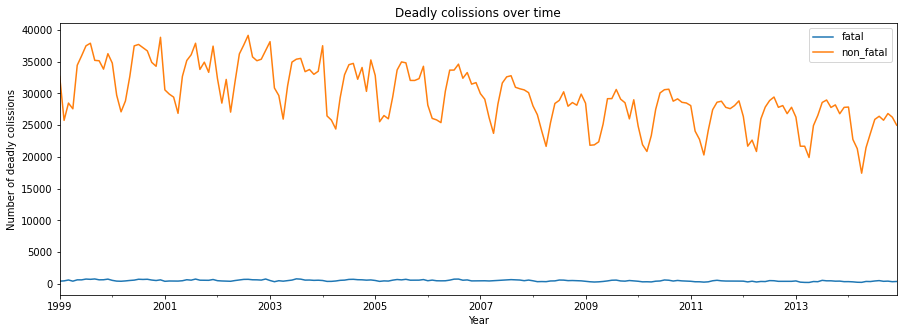

In [ ]:
time_collision_both = df_ts.groupby('date')["fatal","non_fatal"].sum()
plot = time_collision_both.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Podemos observar, como hemos dicho antes que hay muchos más valores en non fatal (que no haya habido muerte en el accidente) y fatal. Además se podríaver que la evolución de accidentes non fatal no es continua, sino que tiene picos y caidas que parecen bastante periódicos, probablemente estacionales.

In [ ]:
### Función mortalidad (% / 100 Accidentes)
def mortalidad(columna, tipos, titulo, data):
    analysis = data.groupby([columna, "fatality"]).size()
    serie = list()
    for i in range(0, np.int8(len(analysis) / 2)):
        serie.append(analysis[:, 1].iloc[[i]].item() / (
                    analysis[:, 1].iloc[[i]].item() + (analysis[:, 0].iloc[[i]].item())) * 100)
    analysis = pd.Series(serie, index=range(0, np.int8(len(analysis) / 2)))
    plt.figure(figsize=(15, 5))
    plot = analysis.plot(kind="bar", title=titulo, color="#3A5683")
    plot.set_xticklabels(tipos, rotation=45)


### Función frecuencia absoluta
def frecuencia(columna, tipos, titulo, data):
    analysis = data.groupby(columna)["fatality"].count()
    plt.figure(figsize=(15, 5))
    plot = analysis.plot(kind="bar", title=titulo, color="#639A88")
    plot.set_xticklabels(tipos, rotation=45)


### Función mortalidad total
def mortalidadtotal(columna, tipos, titulo, data):
    analysis = data.groupby(columna)["fatality"].sum() / data["fatality"].sum() * 100
    plt.figure(figsize=(15, 5))
    plot = analysis.plot(kind="bar", title=titulo, color="#76B041")
    plot.set_xticklabels(tipos, rotation=45)

In [ ]:
def boxplot_fatality(var, data):
    f, ax = plt.subplots(figsize=(14, 6))
    sns.boxplot(x=var, y='fatality', data=data, orient='h')

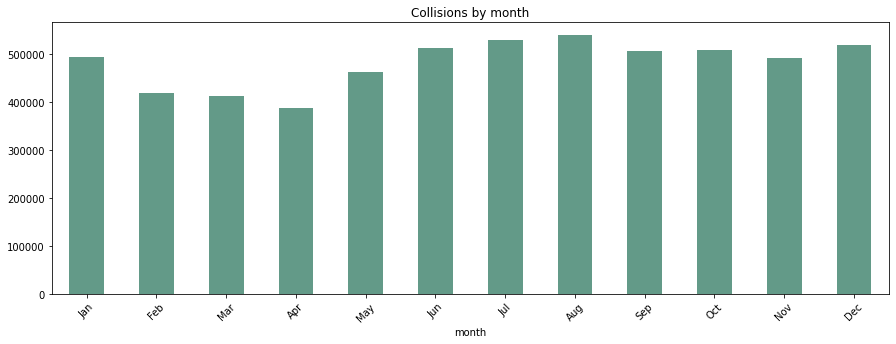

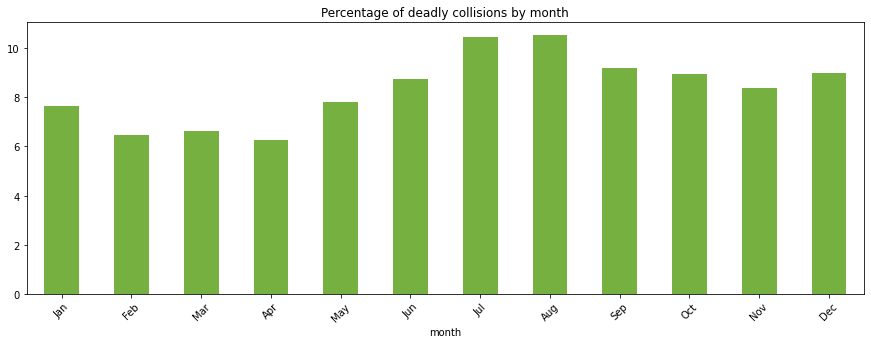

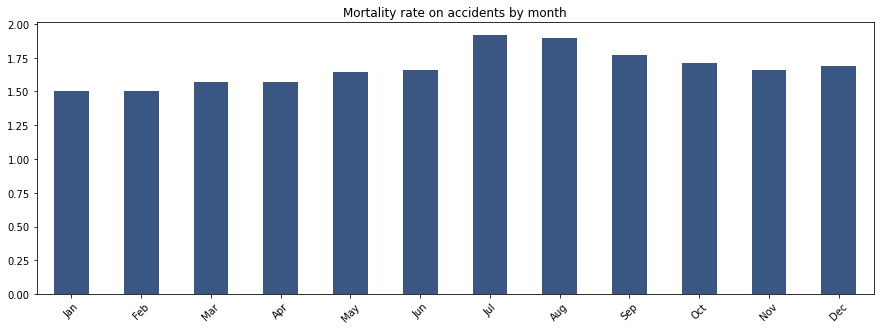

In [ ]:
tipos = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
frecuencia("month", tipos, "Collisions by month", data_df)
mortalidadtotal("month", tipos, "Percentage of deadly collisions by month", data_df)
mortalidad("month", tipos, "Mortality rate on accidents by month", data_df)

Podemos observar que los meses con tendencia a tener mayor numero de accidentes y con mayor mortalidad son en verano, principalmente en Julio y Agosto

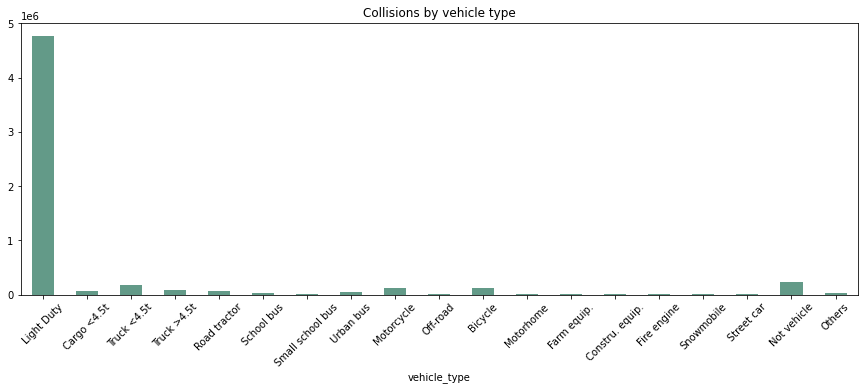

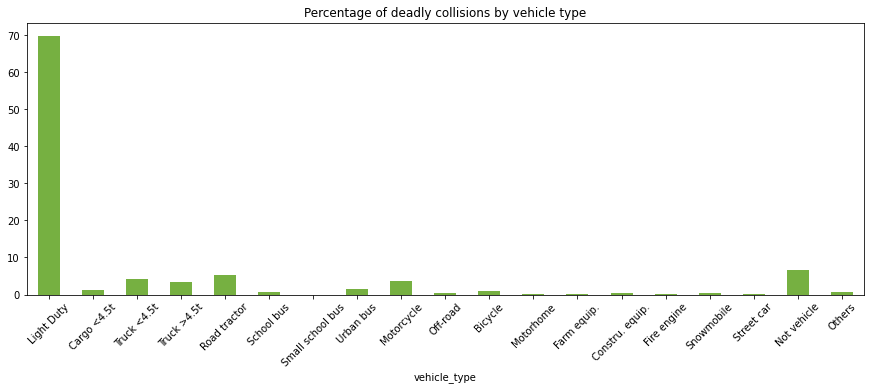

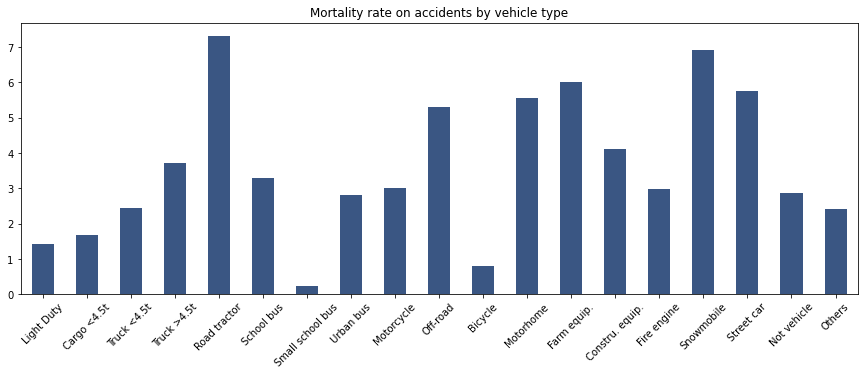

In [ ]:
tipos = v_type = ['Light Duty', 'Cargo <4.5t', 'Truck <4.5t',
          'Truck >4.5t', 'Road tractor', 'School bus',
          'Small school bus', 'Urban bus', 'Motorcycle',
          'Off-road', 'Bicycle', 'Motorhome', 'Farm equip.',
          'Constru. equip.', 'Fire engine', 'Snowmobile',
          'Street car', 'Not vehicle', 'Others']
             
frecuencia("vehicle_type", tipos, "Collisions by vehicle type",data_df)
mortalidadtotal("vehicle_type", tipos, "Percentage of deadly collisions by vehicle type",data_df)
mortalidad("vehicle_type", tipos, "Mortality rate on accidents by vehicle type",data_df)

Podemos observar que los vehiculos con mayor número de accidentes y mas accidentes mortales son los "light Duty"


Text(0.5, 1.0, 'Mortality rate by vehicle age')

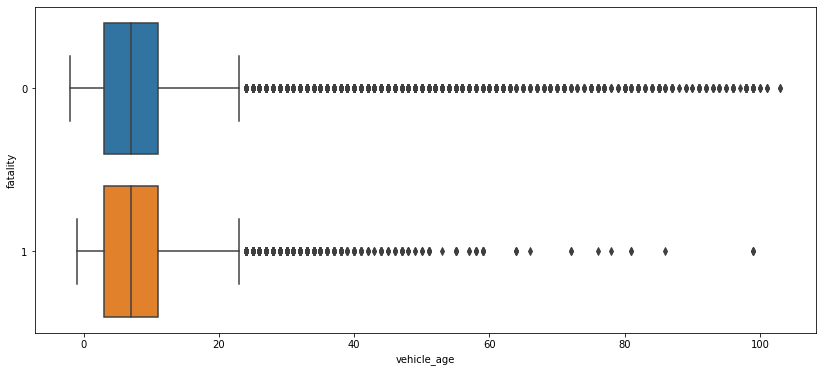

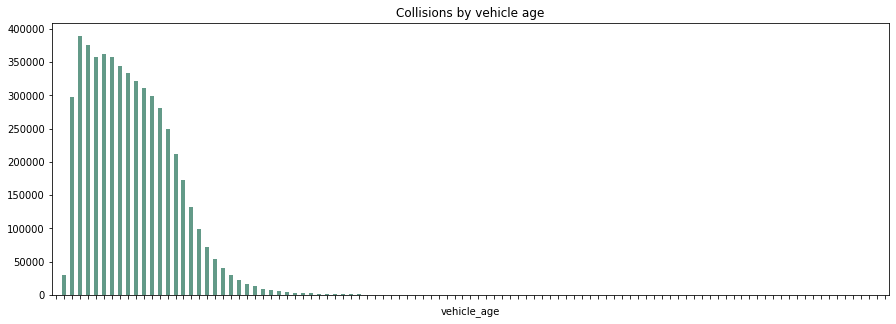

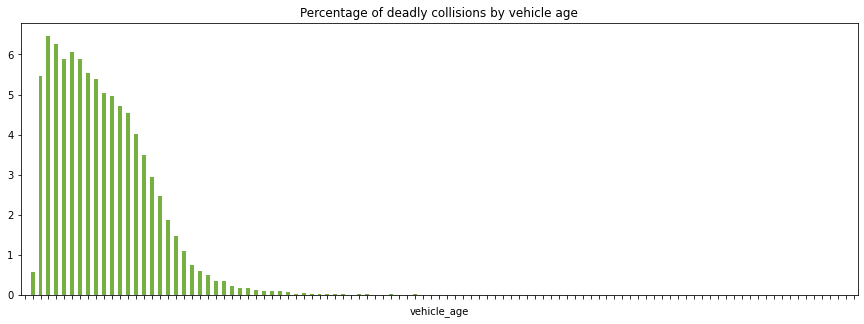

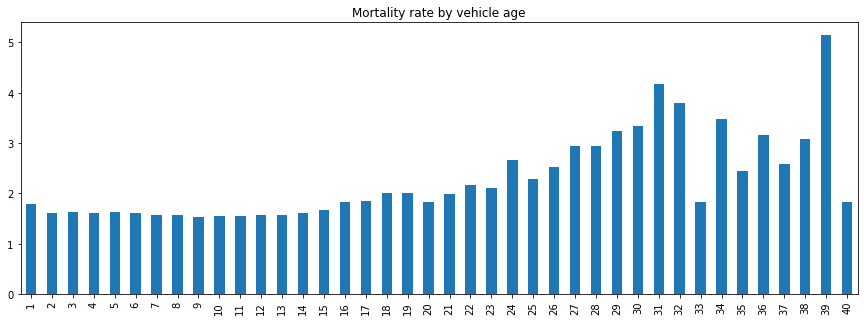

In [ ]:
tipos = ()
boxplot_fatality('vehicle_age',data_df)
frecuencia("vehicle_age", tipos, "Collisions by vehicle age",data_df)
mortalidadtotal("vehicle_age", tipos, "Percentage of deadly collisions by vehicle age",data_df)


analysis = data_df.loc[(data_df['vehicle_age'] < 40) & (data_df['vehicle_age'] >= 0)].groupby(['vehicle_age', "fatality"]).size()
serie = list()
for i in range(0, np.int8(len(analysis)/2)):
    serie.append(analysis[:,1].iloc[[i]].item() / (analysis[:,1].iloc[[i]].item() + (analysis[:,0].iloc[[i]].item())) * 100)  
plt.figure(figsize=(15,5))
pd.Series(serie).plot(kind="bar").set_xticklabels(list(range(1,41)))
plt.title("Mortality rate by vehicle age")

Vemos los primeros años se incrementa enormemente el número de accidentes, pero se va reduciendo gradualmente, asi que de los accidentes hay un mayor número de ellos con coches más nuevos. Pero vemos que hay mayor tasa de mortalidad con coches más antiguos, probablemente por las medidas de seguridad que tienen. 

Ahora analizamos a los conductores

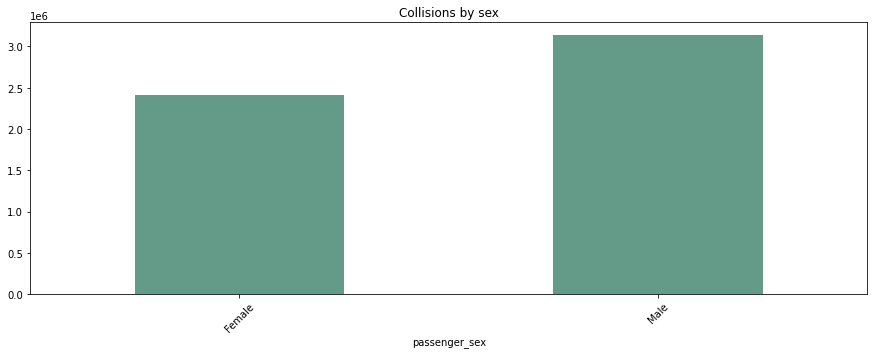

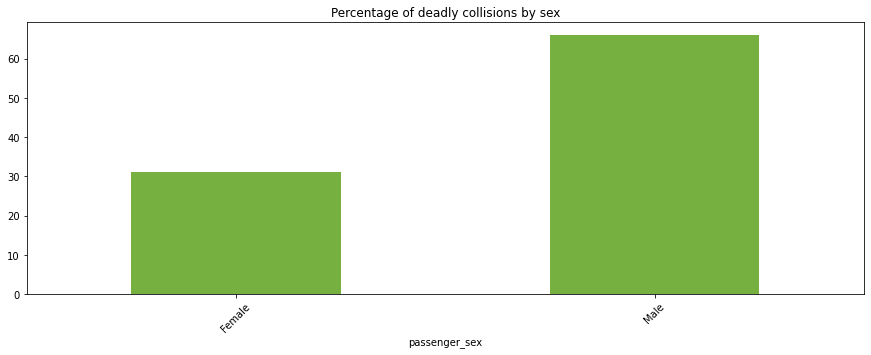

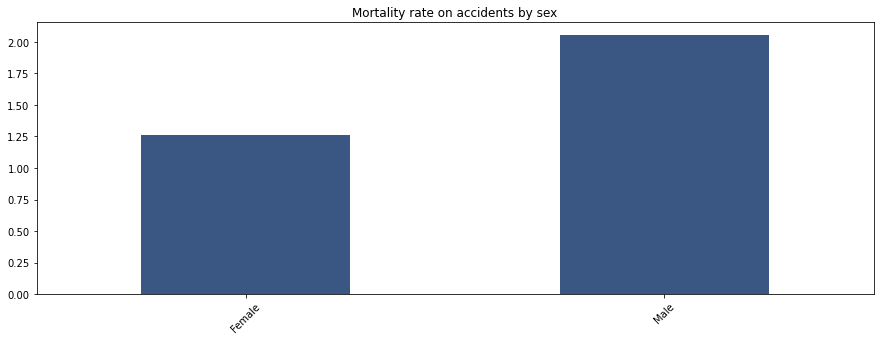

In [ ]:
tipos = ["Female", "Male"]
frecuencia("passenger_sex", tipos, "Collisions by sex", data_df)
mortalidadtotal("passenger_sex", tipos, "Percentage of deadly collisions by sex", data_df)
mortalidad("passenger_sex", tipos, "Mortality rate on accidents by sex", data_df)

Podemos observar que hay un mayor número de accidentes (también mortales) en los que los conductores son hombres y que la tasa de mortalidad es mas alta. 

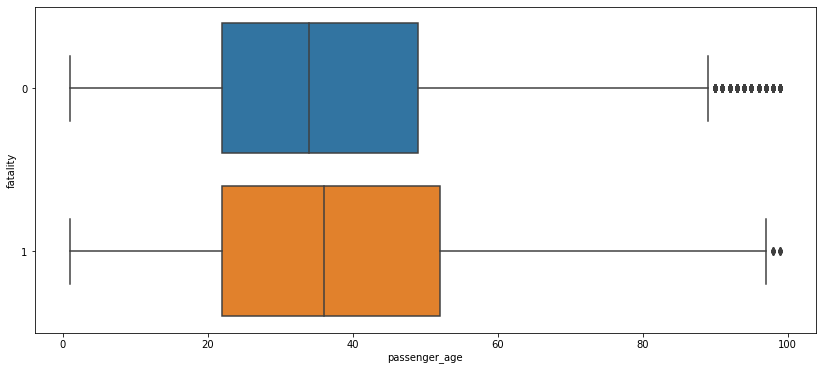

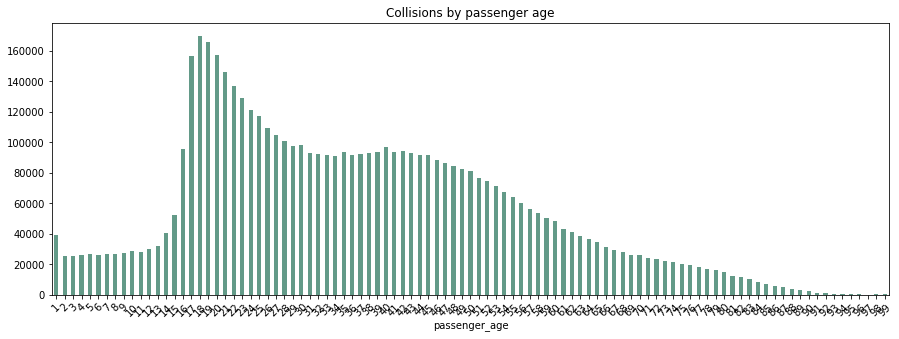

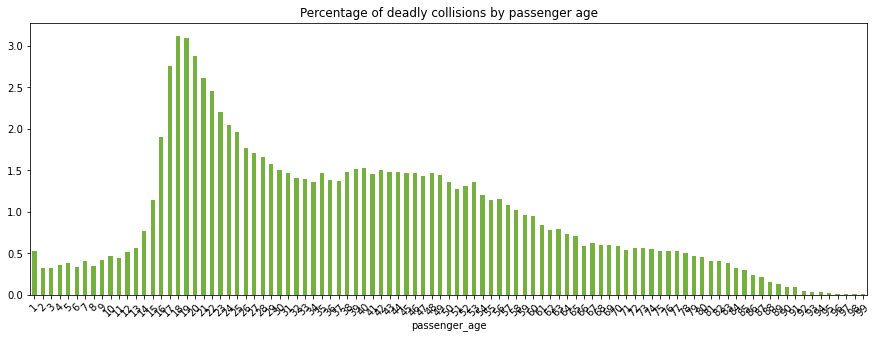

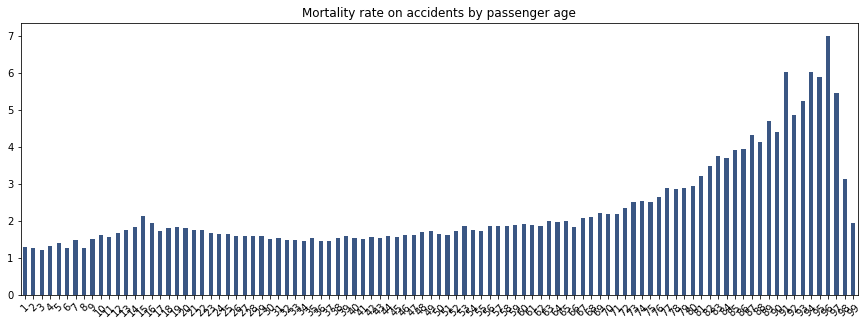

In [ ]:
tipos = sorted(np.int8(data_df['passenger_age'].dropna().unique()))
boxplot_fatality("passenger_age",data_df)
frecuencia("passenger_age", tipos, "Collisions by passenger age",data_df)
mortalidadtotal("passenger_age", tipos, "Percentage of deadly collisions by passenger age",data_df)
mortalidad("passenger_age", tipos, "Mortality rate on accidents by passenger age",data_df)

Podemos observar que los conductores con más accidentes son los jóvenes entre 16 y 25 años, pero que las tasa de mortalidad se incrementa con los años 

In [ ]:
### Función V de Cramer corregido
def cramers_corrected_stat(x,y):
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [ ]:
#Añado fatality a la lista de categoricas para ver como se relacionan con las demás categóricas
if 'fatality' not in categoricas_pre: 
    categoricas_pre.append('fatality')

In [ ]:
# Matriz con valores de la V de Cramer
rows= []
for var1 in categoricas_pre:
  col = []
  for var2 in categoricas_pre :

    cramers =cramers_corrected_stat(data_df[var1], data_df[var2]) # Test V de Cramer
    col.append(round(cramers,2)) 
  rows.append(col)
  
cramers_results = np.array(rows)
cramer_matrix = pd.DataFrame(cramers_results, columns = categoricas_pre, index = categoricas_pre)
cramer_matrix

KeyboardInterrupt: ignored

Vemos que la variable que mas afecta a que el resultado del accidente resulte la muerte, variable fatality, es el tipo de accidente (crash_type)

In [ ]:
data_df

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_sex,passenger_age,passenger_role,passenger_safety,passenger_type,fatality
0,1999,1,1,20,2.0,34,NaN,1,5,3,03,06,9.0,1,41.0,11,NaN,1,0
1,1999,1,1,20,2.0,34,NaN,1,5,3,03,01,12.0,1,19.0,11,NaN,1,0
2,1999,1,1,20,2.0,34,NaN,1,5,3,03,01,12.0,0,20.0,13,02,2,0
3,1999,1,1,8,1.0,01,NaN,5,3,6,18,01,13.0,1,46.0,11,NaN,1,0
4,1999,1,1,8,1.0,01,NaN,5,3,6,18,NN,NaN,1,5.0,99,NaN,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850191,2014,12,7,14,2.0,41,01,1,5,1,18,05,6.0,1,44.0,11,02,1,0
5850192,2014,12,7,14,2.0,41,01,1,5,1,18,05,6.0,1,34.0,13,02,2,0
5850193,2014,12,7,19,1.0,03,01,1,3,4,18,01,13.0,0,35.0,11,02,1,0
5850194,2014,12,7,19,1.0,03,01,1,3,4,18,01,13.0,1,26.0,13,02,2,0


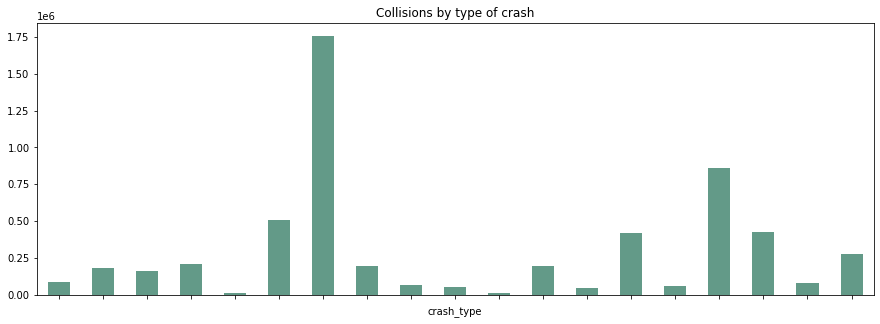

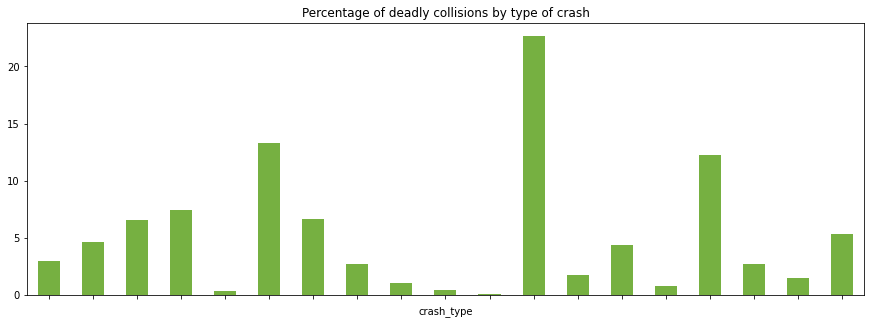

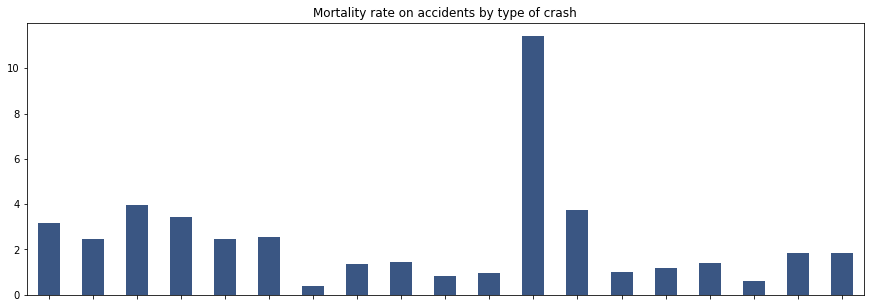

In [ ]:
tipos = []
frecuencia("crash_type", tipos, "Collisions by type of crash", data_df)
mortalidadtotal("crash_type", tipos, "Percentage of deadly collisions by type of crash", data_df)
mortalidad("crash_type", tipos, "Mortality rate on accidents by type of crash", data_df)

Vemos que este gráfico no no aportaría mucho porque no sabemos que tipo de accidente es el que más hay

Ahora vamos a observar la correlación de la variable objetivo

In [ ]:
#plt.figure(figsize=(15,5))
#for c in time_collision_both.columns:
 # autocorrelation_plot(time_collision_both[c][-60:],label=c);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



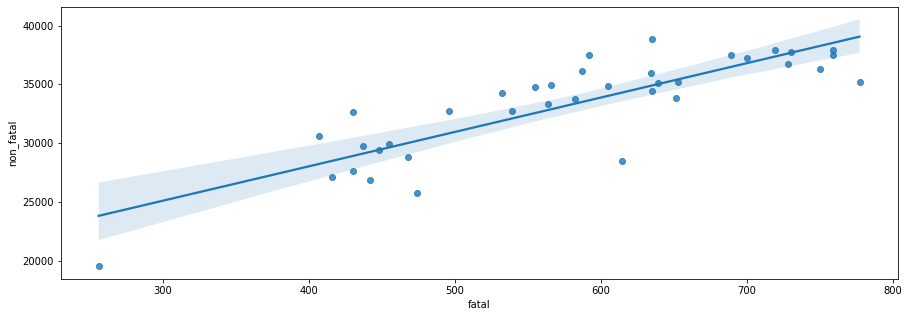

In [ ]:
plt.figure(figsize=(15,5))
sns.regplot('fatal', 'non_fatal', data=time_collision_both);

Existe una correlación lineal entre los accidentes no mortales (non_fatal) y los mortales (fatal), dado que, a mayor cantidad de accidentes habra mayor cantidad de accidentes mortales

In [ ]:
corr = time_collision_both.corr()
print( str(round(corr["fatal"]["non_fatal"], 3)))
corr

0.849


,fatal,non_fatal
fatal,1.000000,0.849249
non_fatal,0.849249,1.000000


La correlación entre los accidentes mortales y los no mortales es de 0.85

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.3 MB/s 


In [ ]:
from category_encoders import TargetEncoder


## **Filtrado de los datos**

Los datos tienen un problema y es que cada fila representa una persona y nuestra variable objetivo es a nivel de accidente.

Hemos decidido filtrar el conjunto de datos para quedarnos solo con los conductores de cada vehículo eliminando al resto de pasajeros:
·eliminamos valores dobles que generarían un problema de overfitting 
·convertimos nuestra información a un caso más realista porque solo tenemos información del asegurado.

In [ ]:
data_df = data_df.loc[(data_df['passenger_role'] == "11") | (data_df['passenger_role'] == "99")]
data_df = data_df.drop('passenger_role', axis = 1)

# **Valores missing y outliers**

In [ ]:

nulos_col = pd.merge(data_df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         data_df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/data_df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
17,passenger_safety,137262,object,0.156918
16,vehicle_age,106743,float64,0.122029
15,crash_place,88050,object,0.100659
14,road_slope,70012,object,0.080038
13,passenger_age,42310,float64,0.048369
12,passenger_sex,32556,object,0.037218
11,traffic_state,30159,object,0.034478
10,crash_type,26834,object,0.030677
9,passenger_type,13792,object,0.015767
8,crash_weather,11969,object,0.013683


Para las categóricas crearemos una nueva categoría con todos los valores missing, en las numéricas imputaremos la mediana.

In [ ]:
data_df = data_df[data_df['vehicles_involved'].notna()]

# **Gráfico d distribución de las variables numéricas**

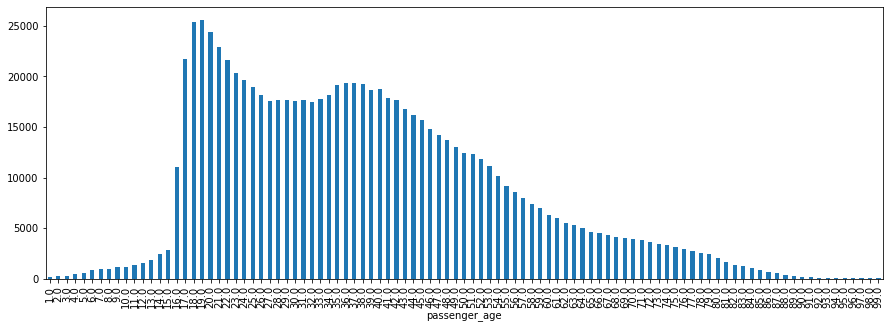

In [ ]:
plt.figure(figsize=(15,5))
pd.concat([data_df], axis=1).groupby(('passenger_age'))['fatality'].count().plot(kind="bar")

Encontramos que hay conductores con una edad muy corta, Outliers claramente 

En los datos pone lo siguiente:
"The data in the NCDB are as reported by the provinces and territories. In some instances a child can be coded as being the driver when they are sitting on the lap of the real driver. In other cases, this would be an error, but there would be no way to determine which cases are the latter"

Con estos valores seguiremos la misma estrategia de imputación que empleemos con los missings.

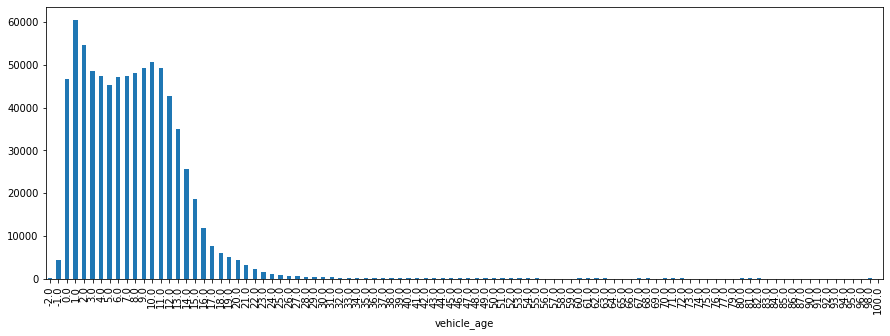

In [ ]:
plt.figure(figsize=(15,5))
pd.concat([data_df], axis=1).groupby(('vehicle_age'))['fatality'].count().plot(kind="bar")

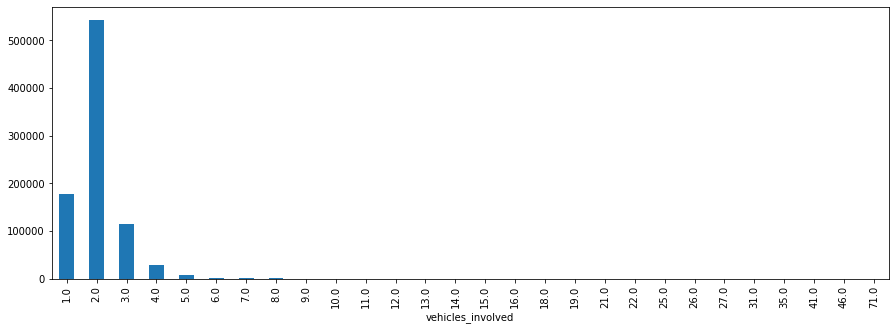

In [ ]:
plt.figure(figsize=(15,5))
pd.concat([data_df], axis=1).groupby(('vehicles_involved'))['fatality'].count().plot(kind="bar")

In [ ]:
# Borramos filas con outliers 
data_df = data_df.loc[(data_df['vehicle_age'] < 30) | (data_df['vehicle_age'].isnull())]
data_df = data_df.loc[(data_df['vehicles_involved'] < 7)  | (data_df['vehicles_involved'].isnull())]

# Transformamos Outliers en nulos para imputar
data_df['passenger_age'][(data_df['passenger_age'] < 13)] = np.nan

# Dividimos las variables en tramos 

In [ ]:
# Convertimos meses en cuatrimestres
data_df['month'] = (data_df['month']-1)//3 + 1
data_df = data_df.rename({'month': 'quarter'}, axis= 1)

In [ ]:
# Reducimos weekday a tres tramos
data_df['weekday'] = data_df['weekday'].replace({6:3, 7:3, 1:2, 4:2, 5:2, 2:1, 3:1})

In [ ]:
# Reducimos horas a seis tramos 
data_df['hour'] = data_df['hour'].replace({0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3, 11:4, 12:4, 13:4, 14:4, 15:4, 16:4, 17:4, 18:4, 19:5, 20:5, 21:5, 22:6, 23:6})

## Pipeline

Creamos tres listas con las variables según el tratamiento que van a recibir:
- _few_cat_: Categóricas con 6 o menos categorías a las que aplicaremos One-Hot Encoding
- _many_cat_: Categóricas con 7 o más categorías a las que aplicaremos Mean Encoding
- _numeric_: Numéricas

In [ ]:
# Categoricas pequeñas para OHE 
few_cat = []
for column in data_df.columns: 
    if (len(data_df[column].unique())< 7):
        few_cat.append(column)

if 'fatality' in few_cat: 
    few_cat.remove('fatality')

# Categoricas grandes para ME
many_cat = []
for column in data_df.columns[data_df.dtypes=='object']: 
    if (len(data_df[column].unique()) > 7):
        many_cat.append(column)

# numericas
numeric = ['vehicle_age', 'passenger_age', 'vehicles_involved', 'year']


Creamos el pipeline de preprocesado que posteriormente aplicaremos de forma conjunta a los modelos.

In [ ]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target', TargetEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('fcat', onehot_transformer, few_cat),
        ('mcat', categorical_transformer, many_cat)])


# **Split en Train y Test**

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(data_df.drop(columns=['fatality']), data_df['fatality'], test_size=0.20, random_state=0)
#xtrain = xtrain.drop(columns="index")
#xtest = xtest.drop(columns="index")

Comprobamos que Test y Train son similares



In [ ]:
#Train
pd.concat([xtrain, pd.DataFrame(ytrain)]).describe().round(3)

,year,quarter,weekday,hour,vehicles_involved,vehicle_age,passenger_age,fatality
count,696356.000,696356.000,696356.000,696356.000,696356.000,611031.000,654963.000,696356.000
mean,2000.032,2.550,1.947,3.719,2.026,7.409,38.238,0.015
std,0.846,1.116,0.729,1.157,0.757,5.160,16.046,0.123
min,1999.000,1.000,1.000,1.000,1.000,-2.000,13.000,0.000
25%,1999.000,2.000,1.000,3.000,2.000,3.000,25.000,0.000
50%,2000.000,3.000,2.000,4.000,2.000,7.000,36.000,0.000
75%,2001.000,4.000,2.000,4.000,2.000,11.000,48.000,0.000
max,2002.000,4.000,3.000,6.000,6.000,29.000,99.000,1.000


In [ ]:
#Train
pd.concat([xtrain, pd.DataFrame(ytrain)]).describe().round(3)

,year,quarter,weekday,hour,vehicles_involved,vehicle_age,passenger_age,fatality
count,696356.000,696356.000,696356.000,696356.000,696356.000,611031.000,654963.000,696356.000
mean,2000.032,2.550,1.947,3.719,2.026,7.409,38.238,0.015
std,0.846,1.116,0.729,1.157,0.757,5.160,16.046,0.123
min,1999.000,1.000,1.000,1.000,1.000,-2.000,13.000,0.000
25%,1999.000,2.000,1.000,3.000,2.000,3.000,25.000,0.000
50%,2000.000,3.000,2.000,4.000,2.000,7.000,36.000,0.000
75%,2001.000,4.000,2.000,4.000,2.000,11.000,48.000,0.000
max,2002.000,4.000,3.000,6.000,6.000,29.000,99.000,1.000


Selección de variables Hemos decidido no emplear ninguna técnica de selección de variables. Esto se debe a que ya de por si tenemos un número reducido de variables y para la mayoría de nuestros modelos no supone ningún problema, más allá de un mayor coste computacional, la introducción de variables correlacionadas o con poco poder predictivo. En los modelos que esto si puede suponer un problema, modelos de regresión, hemos optado por incluir regularización que ayuda a reducir la colinealidad entre variables predictoras.

Oversample (SMOTE) Debido al desbalanceo tan grande presente en nuestros datos optamos también por hacer un Oversample de la clase minoritaria en el conjunto de entrenamiento. Comprobaremos en algunos modelos si esto mejora los resultados con respecto al dataset original


In [ ]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

# Modelo Base y Naive Bayes

En este apartado construimos el modelo base que nos servirá como referencia para comprobar el desempeño del resto de modelos. Por otro lado, también vamos entrenar un modelo Naive Bayes otro modelo sencillo que también nos servirá como referencia. 

In [ ]:
#Librerías
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pickle


# Modelo Base

Un modelo base emplea un valor fijo o valores aleatorios (Normalmente en función de algún estadístico de la distribución de la variable objetivo) para realizar la predicción de los valores del test. 
En nuestro caso hemos empleado la opción 'stratified' que genera predicciones aleatorias respetando la distribución de la variable objetivo.  


In [ ]:
modelo_base = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', DummyClassifier(strategy='stratified', random_state=0))])

In [ ]:
modelo_base.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

In [ ]:
ypred = modelo_base.predict(xtest)
ypred_proba = modelo_base.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.5011155914993903
Accuracy of the model: 0.9701474533141095

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    171436
           1       0.02      0.02      0.02      2653

    accuracy                           0.97    174089
   macro avg       0.50      0.50      0.50    174089
weighted avg       0.97      0.97      0.97    174089


Confusion matrix: 
[[168846   2590]
 [  2607     46]]



# Naive Bayes

El Naive Bayes es un clasificador basado en la aplicación del teorema de Bayes con la hipótesis de independencia condicional entre variables predictoras. Hipótesis conocida como ingenua, _naive_.  
Nosotros hemos aplicado una estimación de Gaussian Naive Bayes

In [ ]:
naive_bayes = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', GaussianNB())])

In [ ]:
naive_bayes.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

In [ ]:
ypred = naive_bayes.predict(xtest)
ypred_proba = naive_bayes.predict_proba(xtest)

## Ajuste del umbral de predicción

In [ ]:
# Coger las probabilidades para los resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calculo roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar el indice con mayor g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.001827, G-Mean=0.720


(164407     0
 42647      0
 1000775    0
 5996       0
 974841     0
           ..
 1057846    0
 337247     0
 767092     0
 605025     0
 843251     0
 Name: fatality, Length: 174089, dtype: int64,
 array([0, 1, 1, ..., 0, 0, 0]),
 array([[9.99939893e-01, 6.01073091e-05],
        [4.05481117e-02, 9.59451888e-01],
        [4.76636960e-01, 5.23363040e-01],
        ...,
        [9.99972519e-01, 2.74811237e-05],
        [9.99987043e-01, 1.29569339e-05],
        [9.99304354e-01, 6.95645990e-04]]))

# Regularización

La regularización trata de penalizar la complejidad del modelo para evitar el overfitting, para ello se añade un término de penalización en la función de coste que tiende a reducir el tamaño de los coeficientes.  

La regularización Ridge o L2 añade la magnitud de los coeficientes al cuadrado como termino de penalización en la función de coste:   

$\sum_{i=1}^{n}\left(y_{i}-\sum_{j=1}^{p} x_{i j} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p} \beta_{j}^{2}$  

La regularización Lasso o L1 añade la magnitud de los coeficientes en valor absoluto como termino de penalización en la función de coste: 

$\sum_{i=1}^{n}\left(Y_{i}-\sum_{j=1}^{p} X_{i j} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p}\left|\beta_{j}\right|$  

El parámetro $\lambda\geq 0$ controla el tamaño de la penalización


In [ ]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pickle
import warnings
warnings.filterwarnings('ignore')

# Regresión Logística (Ridge)

In [ ]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor), 
    ('clasificador', LogisticRegressionCV(cv=8, n_jobs=4, penalty='l2', random_state=0))])

In [ ]:
clf.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

In [ ]:
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.7940255097740839
Accuracy of the model: 0.9847664125820701

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    171436
           1       1.00      0.00      0.00      2653

    accuracy                           0.98    174089
   macro avg       0.99      0.50      0.50    174089
weighted avg       0.98      0.98      0.98    174089


Confusion matrix: 
[[171436      0]
 [  2652      1]]



Vemos que nuestro modelo tiene una precisión del 0,985

## Ajuste del umbral de predicción

In [ ]:
# Quedarse con las probabilidades con resultados positivos unicamente.
yhat = ypred_proba[:, 1]
# Calcular las roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar los que tengan mas g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.014479, G-Mean=0.723


# Regresión Logística (Lasso)

In [ ]:
clf2 = Pipeline(steps=[
    ('preprocesador', preprocessor), 
    ('clasificador', LogisticRegression(C=1.5,random_state=0, n_jobs=2, penalty='l1', solver='liblinear', tol= 0.0005))])

In [ ]:
clf2.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

In [ ]:
ypred = clf2.predict(xtest)
ypred_proba = clf2.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.8026539991094669
Accuracy of the model: 0.9846802497573081

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    171436
           1       0.31      0.00      0.01      2653

    accuracy                           0.98    174089
   macro avg       0.65      0.50      0.50    174089
weighted avg       0.97      0.98      0.98    174089


Confusion matrix: 
[[171411     25]
 [  2642     11]]



Este modelo tiene una precisión del 0.985

## Ajuste del umbral de predicción

In [ ]:
# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar los que tengan mas g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.013513, G-Mean=0.730


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE


# Random Forest

Al utilizar un árbol de decisión, los resultados no son consistentes, y pueden variar-

El Random Forest utiliza muchos árboles, y la decisión final sobre una predicción concreta se basa en un sistema de voto. Este sistema se puede modificar, para ponderar el peso de los votos de los árboles en función de, por ejemplo, su precisión o el ROC-AUC Score (Área debajo de la curva ROC)



Procedemos a entrenar el modelo.



In [ ]:
clf3 = Pipeline(steps=[
    ('preprocesador', preprocessor), 
    
    ('clasificador', RandomForestClassifier(n_jobs=-1, random_state=0))])

In [ ]:
clf3.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

Generamos las predicciones sobre los datos de validación 

In [ ]:
ypred = clf3.predict(xtest)
ypred_proba = clf3.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.8178344956415126
Accuracy of the model: 0.9848181102769273

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    171436
           1       0.53      0.03      0.06      2653

    accuracy                           0.98    174089
   macro avg       0.76      0.52      0.53    174089
weighted avg       0.98      0.98      0.98    174089


Confusion matrix: 
[[171365     71]
 [  2572     81]]



Podemos ver que este modelo tiene un nivel de precisión del 0.9848

## Ajuste del umbral de predicción

In [ ]:
# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular las roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar el indice de mayor g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.020000, G-Mean=0.756


## Comprobación de overfitting

Comprobamos si el modelo sufre de overfitting, realizando una predicción sobre la serie de entrenamiento.

In [ ]:
ypred = clf.predict(xtrain)
ypred_proba = clf.predict_proba(xtrain)

# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular roc curves
fpr, tpr, thresholds = roc_curve(ytrain, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar el indice de mayor g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.015522, G-Mean=0.733


En efecto, el model Random Forest ha realizado un ajuste bastante notable. Posteriormente profundizaremos en este asunto, pero podemos afirmar que el modelo no generaliza bien.

# Random-Forest con SMOTE

En los modelos Random Forest y XGBoost también hemos realizado una prueba con una versión de los datos en los que realizamos un Oversample de la clase minoritaria mediante el algoritmo SMOTE. Probaremos esta técnica en estos primeros dos modelos más complejos con el objetivo de ver si merece la pena. Si consideramos que los resultados son peores a los obtenidos con los datos sin Oversample, nos mantendremos en la senda de usar los datos sin Oversample.

In [ ]:
clf4 = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.4, n_jobs=-1)),
    ('clasificador', RandomForestClassifier(n_jobs=-1, random_state=0))])

In [ ]:
clf4.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

In [ ]:
ypred = clf4.predict(xtest)
ypred_proba = clf4.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.8225602418266359
Accuracy of the model: 0.9845711101792761

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    171436
           1       0.45      0.06      0.11      2653

    accuracy                           0.98    174089
   macro avg       0.72      0.53      0.55    174089
weighted avg       0.98      0.98      0.98    174089


Confusion matrix: 
[[171243    193]
 [  2493    160]]



El modelo sin aplicar el ajuste de threshold no es lo suficientemente descriptivo como para poder compararlo con su versión análoga. Procedemos a realizar dicho ajuste.

## Ajuste del umbral de predicción

In [ ]:
# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.030000, G-Mean=0.755


Podemos observar que en nuestro modelo concreto y para el tratamiento de los datos que hemos realizado, no existe una razón por la que usar la versión Oversample de los datos.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pickle
import warnings


# XGBoost

El XGBoost o extreme gradient boosting es un procedimiento para el ensamblado de algoritmos de Machine Learning. Sus siglas hacen referencia a eXtreme Gradient Boosting. Este método, al contrario que el bagging, no procesa en paralelo los modelos, es más complejo.

El procedimiento es secuencial. Se empieza con un modelo, que entrena con unos datos, y se evalua con un conjunto de test. Una vez evaluado el desempeño de ese primer modelo, se localizan aquellas observaciones en las que el modelo ha tenido más problemas y ha fallado. Estas observaciones tienen más probabilidad de aparecer en los datos para el siguiente modelo, y así sucesivamente. Lo que busca es pulir una y otra vez las observaciones que son difíciles de clasificar.




In [ ]:
clf5 = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', XGBClassifier(n_jobs=-1, random_state=0))])

In [ ]:
clf5.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

Generamos las predicciones sobre los datos de validación y evaluamos el modelo.

In [ ]:
ypred = clf5.predict(xtest)
ypred_proba = clf5.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.8315621043844477
Accuracy of the model: 0.984777900958705

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    171436
           1       0.67      0.00      0.00      2653

    accuracy                           0.98    174089
   macro avg       0.83      0.50      0.50    174089
weighted avg       0.98      0.98      0.98    174089


Confusion matrix: 
[[171433      3]
 [  2647      6]]



## Ajuste del umbral de predicción

In [ ]:
# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar el indice con mayor g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.016397, G-Mean=0.750


Podemos observar como el ajuste del threshold dota al modelo de un mayor recall para los casos de la clase minoritaria, lo cual nos interesa desde un punto de vista práctico a pesar de reducir la precisión y accuracy del modelo.

## Comprobación de overfitting

In [ ]:
ypred = clf5.predict(xtrain)
ypred_proba = clf5.predict_proba(xtrain)

# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular roc curves
fpr, tpr, thresholds = roc_curve(ytrain, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar el indice de mayor g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.014564, G-Mean=0.753


# XGBoost con SMOTE

In [ ]:
clf5.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

In [ ]:
ypred = clf5.predict(xtest)
ypred_proba = clf5.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.8315621043844477
Accuracy of the model: 0.984777900958705

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    171436
           1       0.67      0.00      0.00      2653

    accuracy                           0.98    174089
   macro avg       0.83      0.50      0.50    174089
weighted avg       0.98      0.98      0.98    174089


Confusion matrix: 
[[171433      3]
 [  2647      6]]



El modelo sin aplicar el ajuste de threshold no es lo suficientemente descriptivo como para poder compararlo con su versión análoga. Procedemos a realizar dicho ajuste.

## Ajuste del umbral de predicción

In [ ]:
# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# calcular roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.016397, G-Mean=0.750


Tras realizar el ajuste del modelo, podemos afirmar que en nuestro caso concreto y para el tratamiento de los datos que hemos realizado, no existe una razón por la que usar la versión Oversample de los datos.
Los resultados obtenidos son peores respecto del modelo generado con datos sin alterar.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

import lightgbm as lgb
from sklearn.pipeline import Pipeline
import pickle
import warnings
warnings.filterwarnings('ignore')




# LightGBM

LightGBM es un clasificador que utiliza técnicas homólogas a las que utiliza XGBoost, pero se encuentra más optimizado que XGBoost permitiendo una mayor velocidad de entrenamiento y mayor eficiencia.
A diferencia de XGBoost, utiliza aprendizaje en paralelo.


In [ ]:
clf6 = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', lgb.LGBMClassifier(n_jobs=-1, random_state=0))])

In [ ]:
clf6.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

Generamos las predicciones sobre los datos de validación y evaluamos el modelo.

In [ ]:
ypred = clf6.predict(xtest)
ypred_proba = clf6.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.8493610274689328
Accuracy of the model: 0.9847262032638479

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    171436
           1       0.46      0.01      0.03      2653

    accuracy                           0.98    174089
   macro avg       0.72      0.51      0.51    174089
weighted avg       0.98      0.98      0.98    174089


Confusion matrix: 
[[171391     45]
 [  2614     39]]



## Ajuste del umbral de predicción

In [ ]:
# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar el indice con mayor g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.014774, G-Mean=0.766


Podemos observar como el ajuste del threshold dota al modelo de un mayor recall para los casos de la clase minoritaria, lo cual nos interesa desde un punto de vista práctico a pesar de reducir la precisión y accuracy del modelo. 

El modelo LightGBM ha devuelto muy buenos resultados. A su vez, el tiempo de ejecución necesario para entrenar el modelo ha sido ínfimo en comparación con los anteriores.

## Comprobación de overfitting

In [ ]:
ypred = clf.predict(xtrain)
ypred_proba = clf.predict_proba(xtrain)

# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular roc curves
fpr, tpr, thresholds = roc_curve(ytrain, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar el indice con mayor g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.015522, G-Mean=0.733


El modelo LightGBM ha sido sorprendentemente bueno, teniendo en cuenta que cumple tres condiciones indispensables a la hora de generar un modelo:

- Buenos resultados
- Bajo tiempo de ejecución
- Ausencia de overfitting

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

import pickle
import warnings
warnings.filterwarnings('ignore')



# ADA Boost

ADA Boost es un clasificador, cuyo algoritmo se basa en la predicción iterativa de "bloques" de datos que va ajustando. 

![Highway](https://programmerclick.com/images/649/93a1dcc89731b8e5fc4dd19b7967f169.png)

![Highway](https://editor.analyticsvidhya.com/uploads/626591024px-Ensemble_Boosting.svg.png)

In [ ]:
clf7 = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', AdaBoostClassifier(n_estimators=100, random_state=0))])

In [ ]:
clf7.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vehicle_age',
                                                   'passenger_age',
                                                   'vehicles_involved',
                                                   'year']),
                                                 ('fcat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                

Generamos las predicciones sobre los datos de validación y evaluamos el modelo.

In [ ]:
ypred = clf7.predict(xtest)
ypred_proba = clf7.predict_proba(xtest)

evaluate_model(ytest,ypred,ypred_proba)


ROC-AUC score of the model: 0.8286676014048187
Accuracy of the model: 0.9846342962507683

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    171436
           1       0.37      0.01      0.02      2653

    accuracy                           0.98    174089
   macro avg       0.68      0.51      0.51    174089
weighted avg       0.98      0.98      0.98    174089


Confusion matrix: 
[[171384     52]
 [  2623     30]]



## Ajuste del umbral de predicción

In [ ]:
# Quedarse con las probabilidades que dan resultados positivos unicamente
yhat = ypred_proba[:, 1]
# Calcular roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# Localizar el indice con mayor g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.489484, G-Mean=0.748


El efecto del ajuste del threshold sobre el modelo ha sido parecido al observado en el resto de modelos. 

## Comprobación de overfitting

In [ ]:
ypred = clf.predict(xtrain)
ypred_proba = clf.predict_proba(xtrain)

# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytrain, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)


Best Threshold=0.015522, G-Mean=0.733


In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

from catboost import CatBoostClassifier 
from sklearn.pipeline import Pipeline


import pickle
import warnings
warnings.filterwarnings('ignore')




ModuleNotFoundError: ignored

# Selección del modelo

In [ ]:
def model_analysis(modelo, xtest, ytest):
    matplotlib.rcParams['figure.figsize'] = (9, 9)
    ypred = modelo.predict(xtest)
    ypred_proba = modelo.predict_proba(xtest)
    # Quedarse con las probabilidades que dan resultados positivos unicamente
    yhat = ypred_proba[:, 1]
    # Calcular roc curves
    fpr, tpr, thresholds = roc_curve(ytest, yhat)
    # plot de la curve roc para el modelo
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=re.findall('^[A-z]+', str(modelo)))
    # Ponemos los indices del grafico
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # mostramos el plot
    plt.show()

    gmeans = np.sqrt(tpr * (1 - fpr))
    # localizar el indez con mayor g-mean
    ix = np.argmax(gmeans)

    # print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    # plot de la curve roc para el modelo
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=re.findall('^[A-z]+', str(modelo)))
    plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
    # Ponemos los indices del grafico
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # mostramos el plot
    plt.show()

    ypred_new_threshold = (ypred_proba[:, 1] > thresholds[ix]).astype(int)

    # Hacemos el plot de la matriz de confusión no normalizada
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred_new_threshold,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

    evaluate_model(ytest, ypred_new_threshold, ypred_proba)

In [ ]:
# Manipulacion
import pandas as pd
import numpy as np

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#from matplotlib_dashboard import MatplotlibDashboard
# Métricas 
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix # Matriz confusion
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import pickle
import re
import warnings
warnings.filterwarnings('ignore')


# Cargamos datos

# Selección de Modelos


En este apartado vamos a utilizar la función 
**model_analysis** que creamos y nos va a permitir observar para cada uno de los modelos generados lo siguiente que nos interes:

1.   La Curva ROC del modelo
2.   La Curva junto con el ajuste de threshold representado visualmente
3.  Classification report
4.  Matrices de confusión del modelo (normalizadas y no )



# Modelo Base

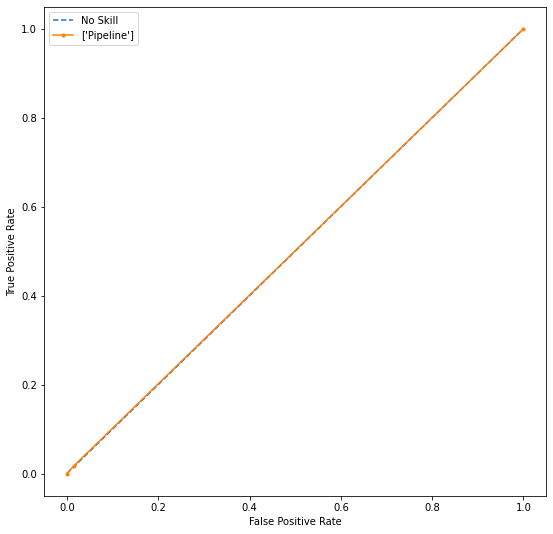

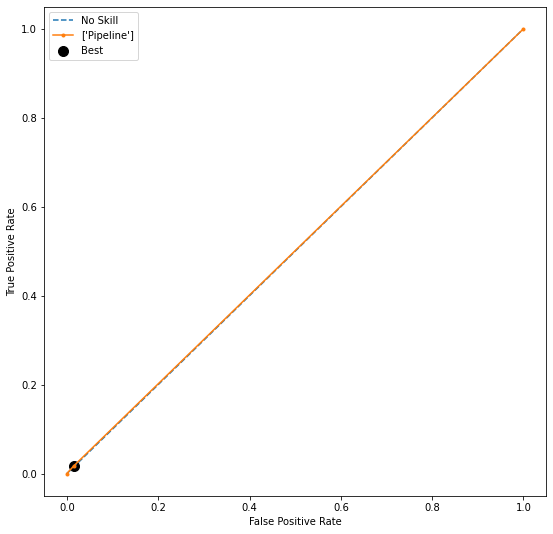

ROC-AUC score of the model: 0.5011155914993903
Accuracy of the model: 0.9847606683937526

Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    171436
           1       0.00      0.00      0.00      2653

    accuracy                           0.98    174089
   macro avg       0.49      0.50      0.50    174089
weighted avg       0.97      0.98      0.98    174089


Confusion matrix: 
[[171436      0]
 [  2653      0]]



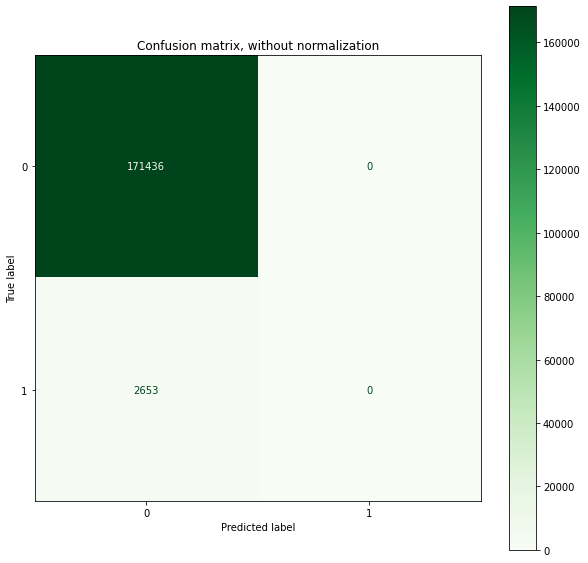

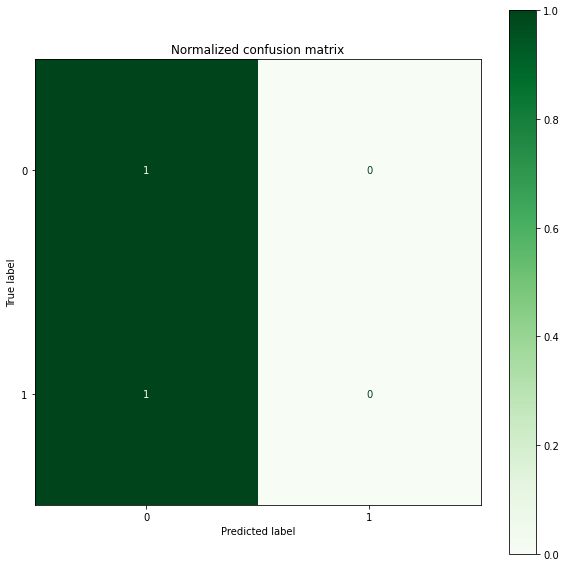

In [ ]:
model_analysis(modelo_base, xtest, ytest)

# Naive-Bayes

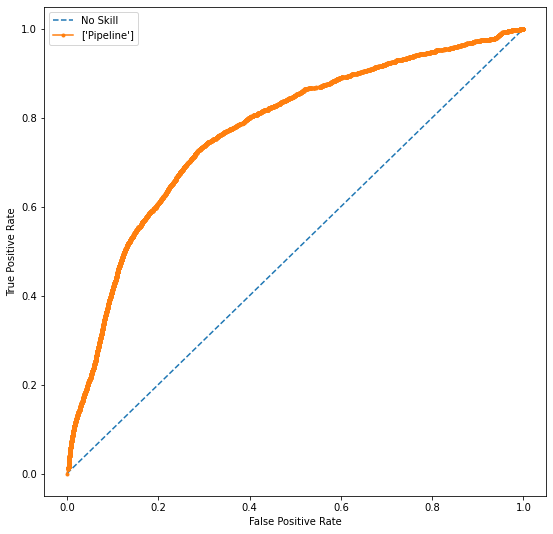

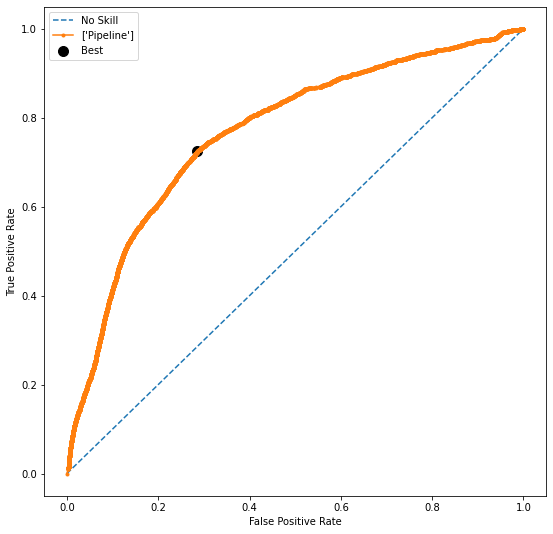

ROC-AUC score of the model: 0.7676676468909742
Accuracy of the model: 0.7150480501352756

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    171436
           1       0.04      0.72      0.07      2653

    accuracy                           0.72    174089
   macro avg       0.52      0.72      0.45    174089
weighted avg       0.98      0.72      0.82    174089


Confusion matrix: 
[[122561  48875]
 [   732   1921]]



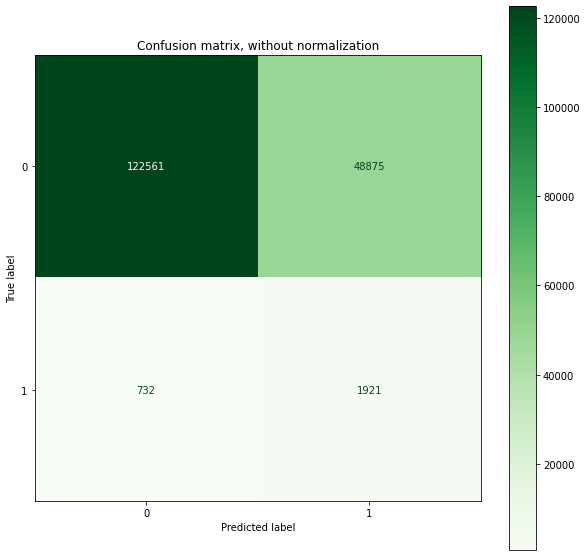

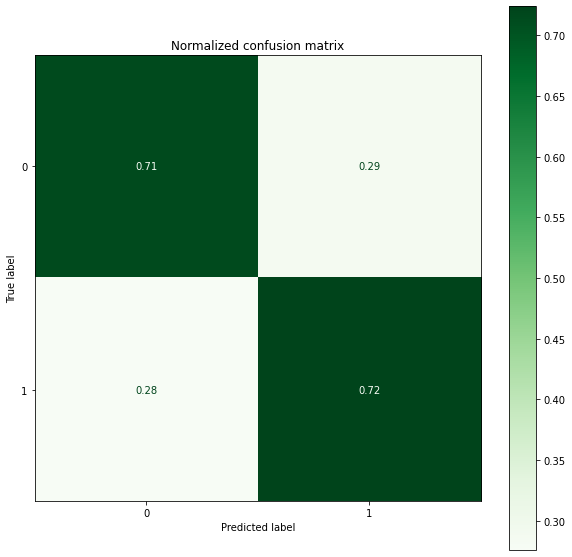

In [ ]:
model_analysis(naive_bayes, xtest, ytest)

# Regresión Logística (Ridge)

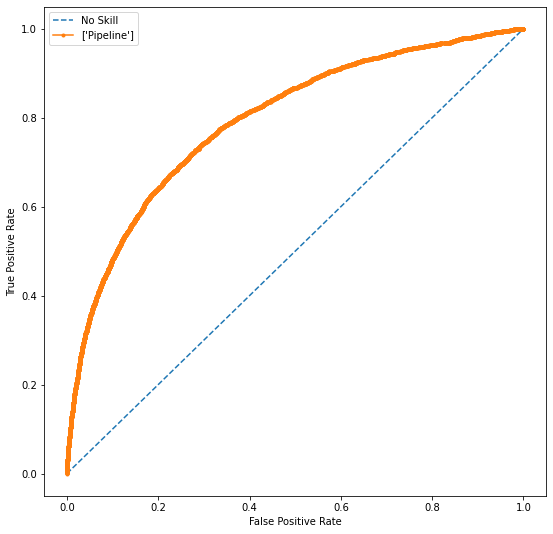

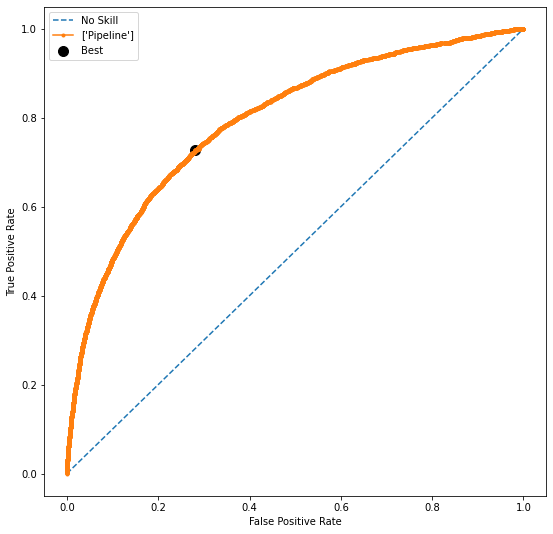

ROC-AUC score of the model: 0.7940255097740839
Accuracy of the model: 0.7186611445869642

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.72      0.83    171436
           1       0.04      0.73      0.07      2653

    accuracy                           0.72    174089
   macro avg       0.52      0.72      0.45    174089
weighted avg       0.98      0.72      0.82    174089


Confusion matrix: 
[[123182  48254]
 [   724   1929]]



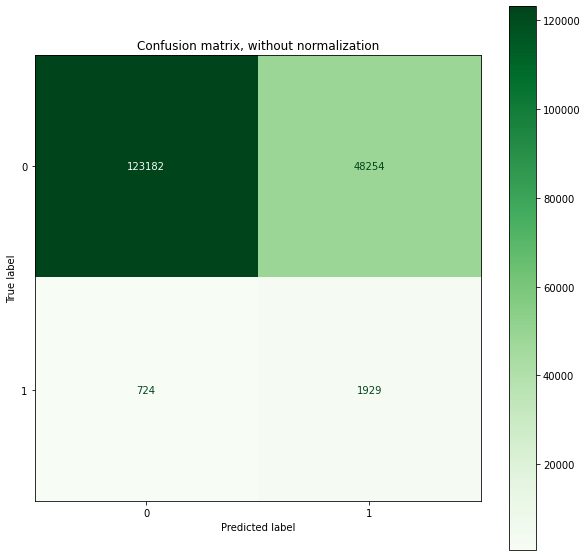

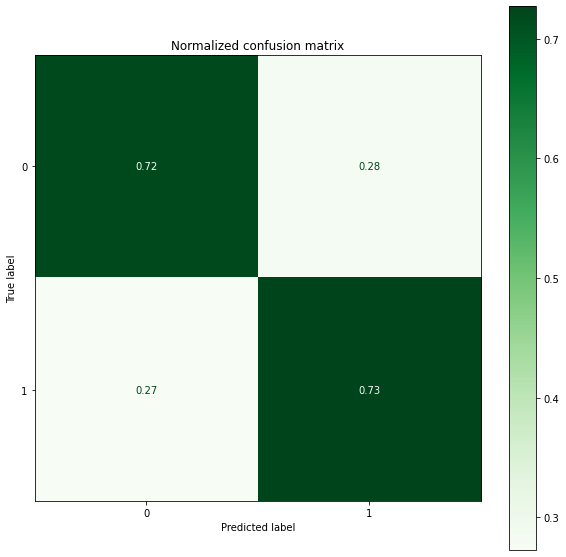

In [ ]:
model_analysis(clf, xtest, ytest)

## Regresión Logística (Lasso)

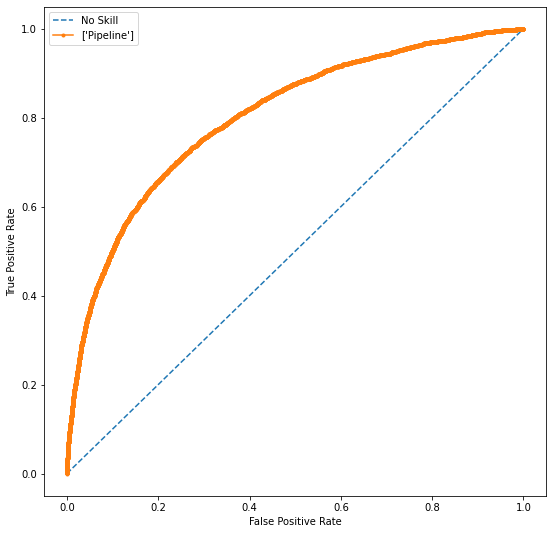

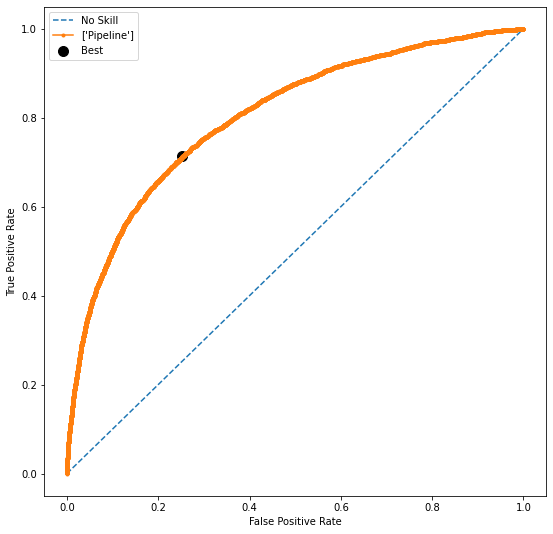

ROC-AUC score of the model: 0.8026539991094669
Accuracy of the model: 0.7463423880888511

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    171436
           1       0.04      0.71      0.08      2653

    accuracy                           0.75    174089
   macro avg       0.52      0.73      0.47    174089
weighted avg       0.98      0.75      0.84    174089


Confusion matrix: 
[[128039  43397]
 [   762   1891]]



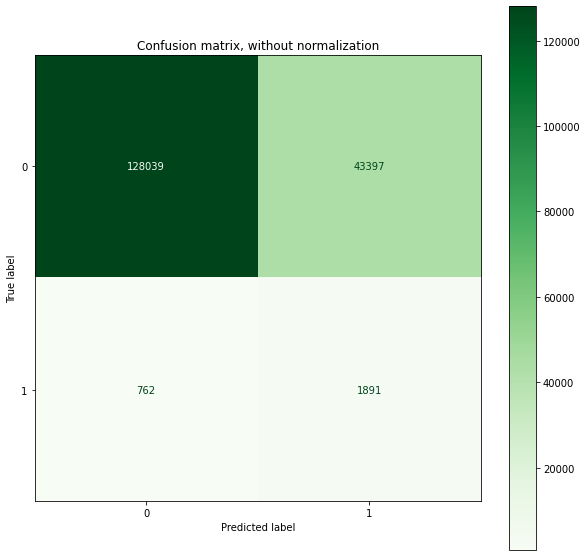

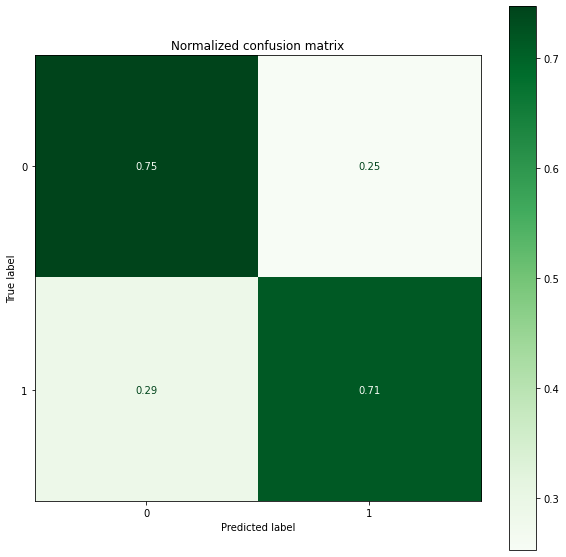

In [ ]:
model_analysis(clf2, xtest, ytest)

# Random Forest

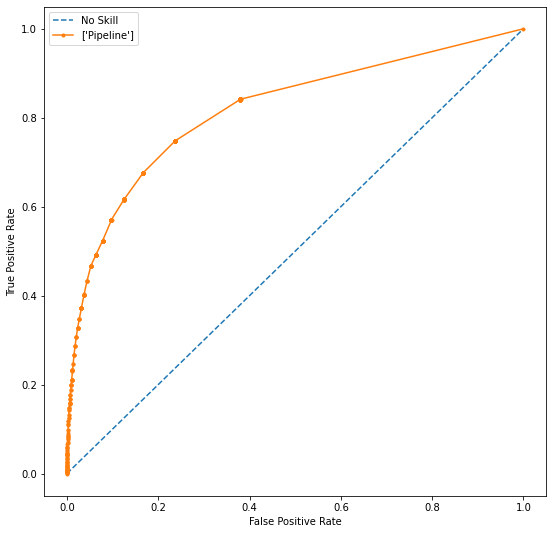

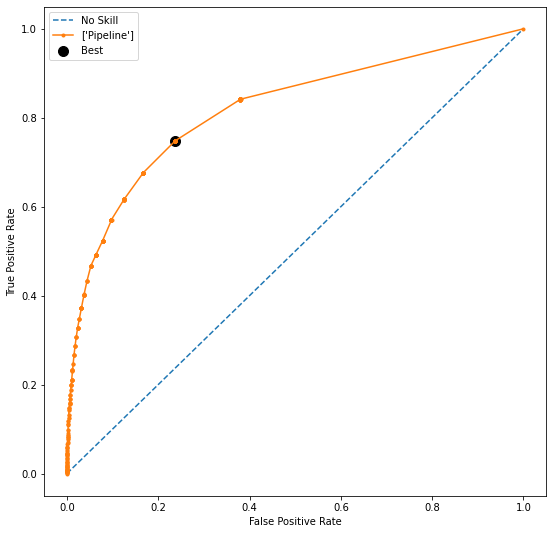

ROC-AUC score of the model: 0.8178344956415126
Accuracy of the model: 0.8309198168752764

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.83      0.91    171436
           1       0.06      0.68      0.11      2653

    accuracy                           0.83    174089
   macro avg       0.53      0.75      0.51    174089
weighted avg       0.98      0.83      0.89    174089


Confusion matrix: 
[[142861  28575]
 [   860   1793]]



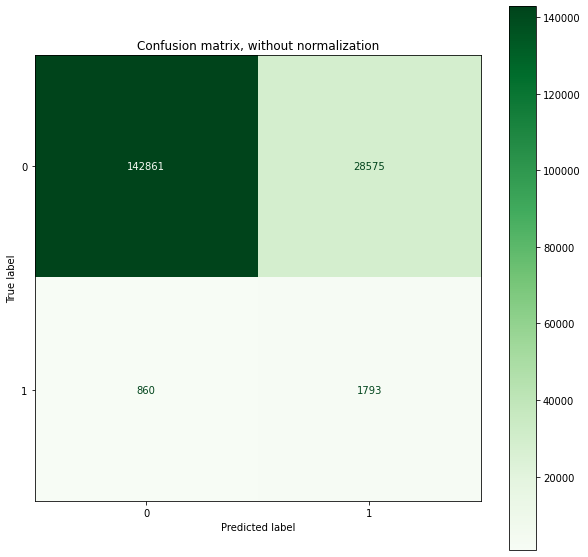

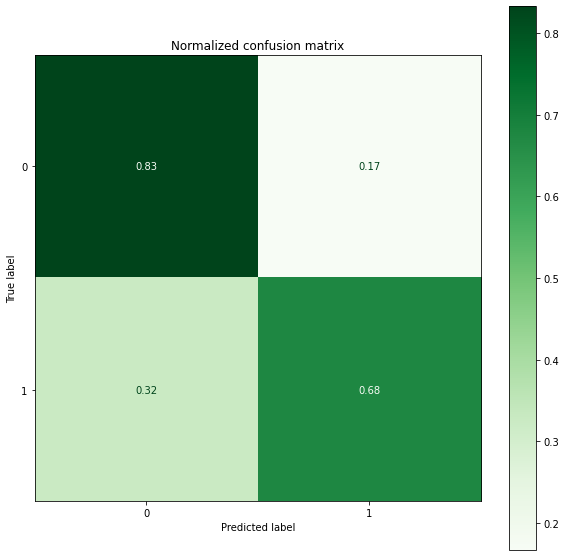

In [ ]:
model_analysis(clf3, xtest, ytest)

# XGBoost


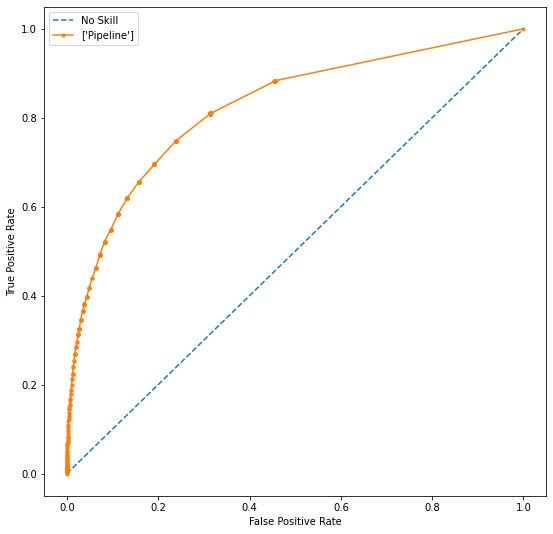

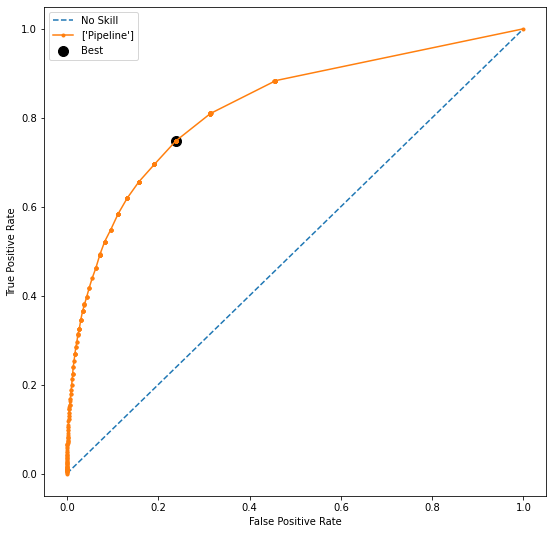

ROC-AUC score of the model: 0.8225602418266359
Accuracy of the model: 0.8064438304545376

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    171436
           1       0.05      0.70      0.10      2653

    accuracy                           0.81    174089
   macro avg       0.52      0.75      0.50    174089
weighted avg       0.98      0.81      0.88    174089


Confusion matrix: 
[[138548  32888]
 [   808   1845]]



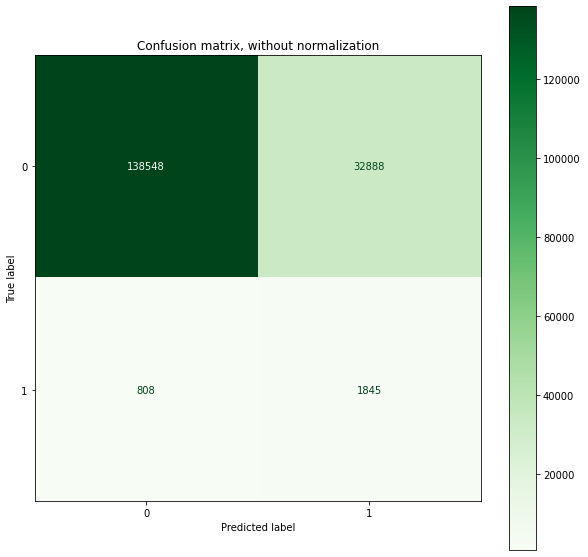

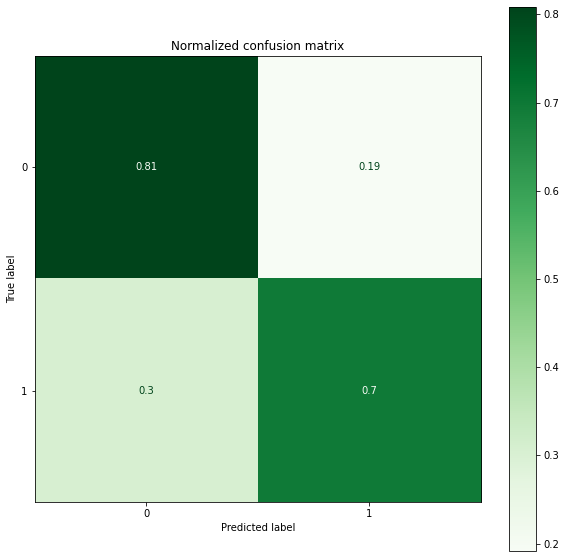

In [ ]:
model_analysis(clf4, xtest, ytest)

# LightGBM

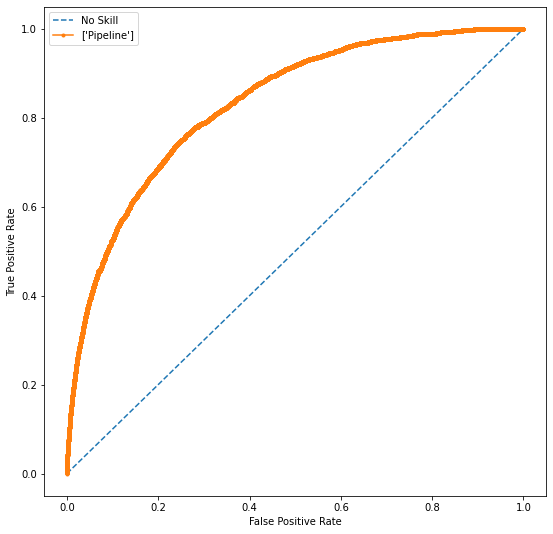

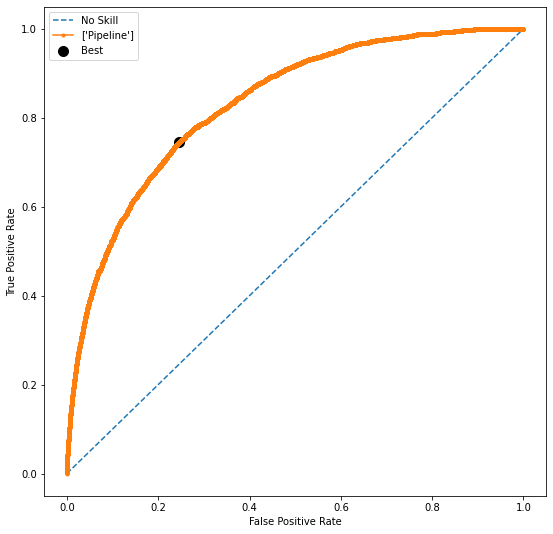

ROC-AUC score of the model: 0.8315621043844477
Accuracy of the model: 0.7541257632590227

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.75      0.86    171436
           1       0.04      0.75      0.08      2653

    accuracy                           0.75    174089
   macro avg       0.52      0.75      0.47    174089
weighted avg       0.98      0.75      0.85    174089


Confusion matrix: 
[[129308  42128]
 [   676   1977]]



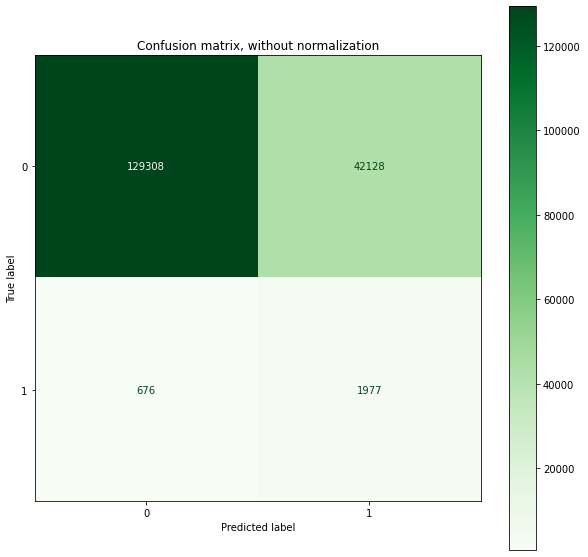

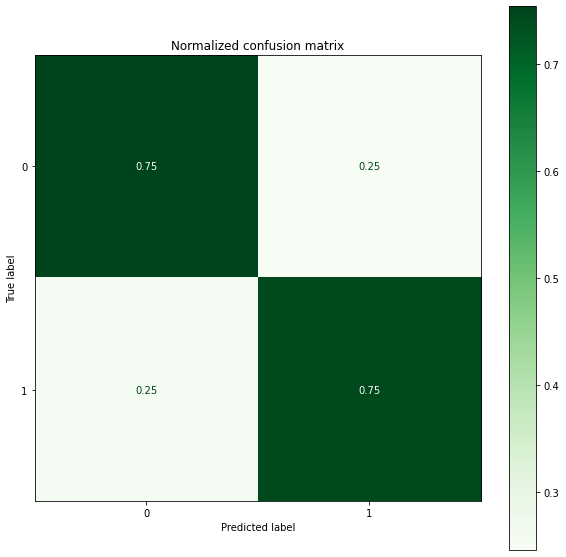

In [ ]:
model_analysis(clf5, xtest, ytest)

# ADA Boost

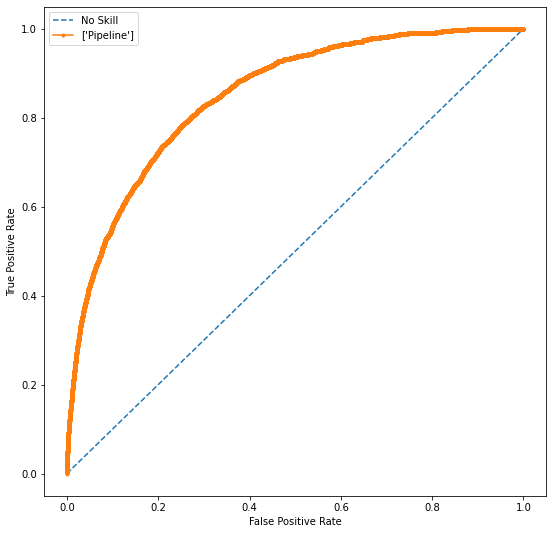

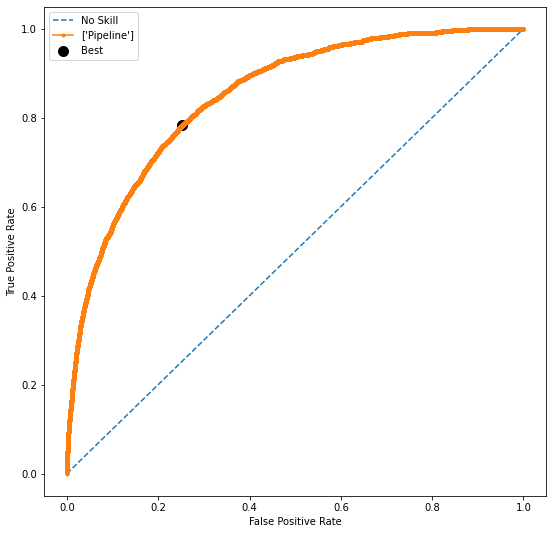

ROC-AUC score of the model: 0.8493610274689328
Accuracy of the model: 0.748272435363521

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.75      0.85    171436
           1       0.05      0.78      0.09      2653

    accuracy                           0.75    174089
   macro avg       0.52      0.77      0.47    174089
weighted avg       0.98      0.75      0.84    174089


Confusion matrix: 
[[128186  43250]
 [   573   2080]]



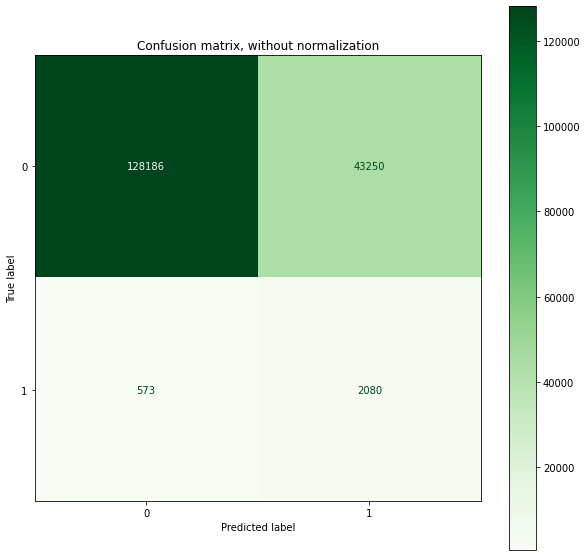

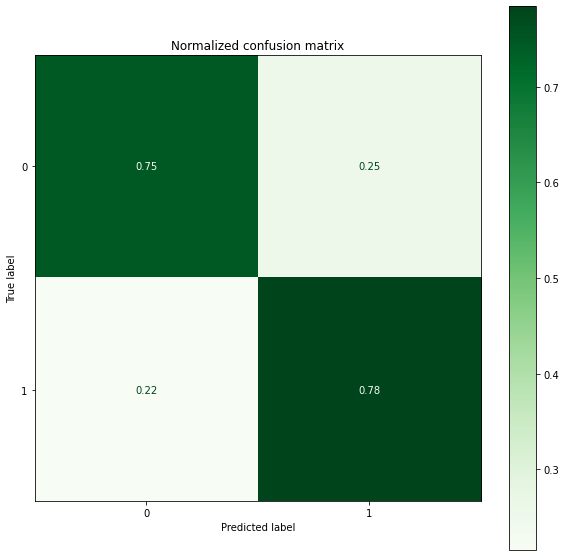

In [ ]:
model_analysis(clf6, xtest, ytest)

# Resumen comparativo

In [ ]:
# Tabla con los datos de cada modelo

datos_modelos = {'Modelo': ['Modelo base', 'Naive-Bayes', 'Ridge', 'Lasso', 'Random Forest','XGBoost','LightGBM', 'ADABoost', 'Catboost'],

                'Accuracy': ['0.98', '0.62', '0.63', '0.63', '0.77', '0.77', '0.75', '0.74', '0.76'],

                'ROC-AUC': ['0.5', '0.69', '0.66', '0.68', '0.81', '0.85', '0.85', '0.82', '0.84'],

                'False positives': ['0', '0.38', '0.37', '0.37', '0.22', '0.25', '0.24', '0.26', '0.24'],

                'True positives': ['0', '0.70', '0.61', '0.63', '0.77', '0.78', '0.77', '0.75', '0.76'],

                'Runtime (s)':['1', '6', '816', '102', '260', '141', '15', '562', '196']}

tabla_modelos = pd.DataFrame(datos_modelos, columns=['Modelo', 'Accuracy', 'ROC-AUC', 'False positives',
                                                    'True positives', 'Runtime (s)'])

Hemos realizado una tabla que realiza una comparación de los resultados y componentes principales para poder evaluar los modelos.

Es necesario recordar que el objetivo de este trabajo es tratar de predecir la mortalidad en accidentes de tráfico, lo cual nos coloca en un entorno con un dataset extremadamente desbalanceado.

Debido a esta inestabilidad o desbalanceado las métricas que a utilizar para medir la calidad de las predicciones hechas se ven afectadas respecto que por lo general se encuentre más balanceado.

Hemos seleccionado los siguientes valores de cada modelo:

1.  **Accuracy**

% total de los valores que ha sido predicho correctamente.

2.  **ROC-AUC**

Área por debajo de la curva ROC. A mayor valor del ROC-AUC, mayor es el cociente entre los *TP* y los *FP*. Evaluaremos positivamente e tener un mayor ROC-AUC.

3. **False positive rate**

Se trata del % de valores (dentro del total de valores negativos) que clasificamos como positivos, pero resultan ser negativos. Lo evaluaremos de manera negativa.

4. **True positive rate**

Se trata del % de valores (dentro del total de valores positivos) que clasificamos como positivos. Lo evaluaremos de manera positiva.

5. **Run time**

Se trata del tiempo de ejecución y por ello representa el tiempo que ha tardado el modelo en ajustarse a los datos de entrenamiento. Mayor tiempo de ejecución, se valorará de manera negativa. 

En esta imagen vemos ilustrado el comportamiento del subconjunto de la predicción dentro de una población.

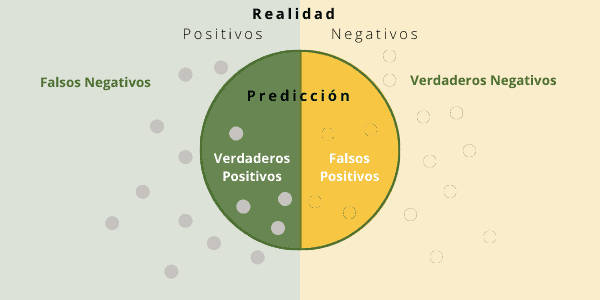

In [ ]:
tabla_modelos

,Modelo,Accuracy,ROC-AUC,False positives,True positives,Runtime (s)
0,Modelo base,0.98,0.5,0,0,1
1,Naive-Bayes,0.62,0.69,0.38,0.70,6
2,Ridge,0.63,0.66,0.37,0.61,816
3,Lasso,0.63,0.68,0.37,0.63,102
4,Random Forest,0.77,0.81,0.22,0.77,260
5,XGBoost,0.77,0.85,0.25,0.78,141
6,LightGBM,0.75,0.85,0.24,0.77,15
7,ADABoost,0.74,0.82,0.26,0.75,562
8,Catboost,0.76,0.84,0.24,0.76,196


## ¿Qué modelos optimizaremos?
 
Descartamos los modelos Base, Naive-Bayes, Ridge y Lasso por la baja tasa de TP* que nos brindan. Nuestro objetivo principal es la predicción de la *mortalidad (clase 1)*, asumiendo cierto coste de oportunidad perdido en la predicción de la *no-mortalidad (clase 0)*
 
El modelo **Random Forest**
 
Predijo = 77% de las muertes y falló = 22% de los accidentes no mortales. Su tiempo de ejecución se encuentra a mitad de la tabla.
 
El modelo **XGBoost** 
Obtiene buenos resultados, teniendo el segundo más bajo de los tiempos de ejecución y obteniendo el mejor resultado en cuanto a los *TP*
 
El modelo **LightGBM** 
Obtiene resultados parecidos al modelo anterior y destaca en su tiempo de ejecución con solamente 15 segundos. 
 
El modelo **ADA Boost**
Se ve superado por los demás modelos de boosting, obteniendo los peores resultados de estos y con un “run time”= 562 segundos.
 
El modelo **Cat Boost** obtuvo resultados relativamente buenos y un run time adecuado.
 
## Decisión
 
Por todo ello, hemos decidido utilizar en la siguiente fase del proyecto los soguientes modelos: 
 
- **LightGBM** 
 
ya que fue eficiente y sus resultados basicamente homologos a los obtenidos a traves de XGBoost, por lo que lo optimizaremos.
 
- **Random Forest** 
 
Se trata de un modelo que tiende a volverse más robusto cuanto más profundo e intensivo es su entrenamiento, por lo que a pesar de haber obtenido peores resultados que los modelos de boosting intentaremos optimizarlo.


## OPTIMIZACION

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer

warnings.filterwarnings('ignore')



In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV


# Optimización de modelos

# Light GBM
Como hemos visto el GBM ligero es una estructura rápida, apropiada y impulso de gradiente que depende del calculo del árbol de elección y se utiliza para el posicionamiento, la caracterización y otras numerosas asignaciones. 
 
Vamos a generarun campo de parametro en el que las combinaciones se aprobaran con la busqueda Grid, e ira descartando combinaciones de parametros si determina que ha encontrado un “camino” que genere modelos más precisos.
 
Utilizaremos el ROC-AUC score como métrica a optimizar.



In [ ]:
lightgbm = Pipeline(steps=[('preprocessor', preprocessor),
                            ('clasificador', lgb.LGBMClassifier())])

In [ ]:
param_grid = { 
    'clasificador__is_unbalance': [True],
    'clasificador__max_depth': [-1],
    'clasificador__objective': ['binary'],
    'clasificador__learning_rate': [0.1, 0.05], 
    'clasificador__n_estimators' : [200, 300, 400], 
    'clasificador__importance_type' : ['split', 'gain'],
    'clasificador__num_leaves': [50, 100, 200]
    }

CV = GridSearchCV(lightgbm, param_grid, cv=3, n_jobs=8, scoring='roc_auc', verbose=1)

In [ ]:
CV.fit(xtrain,ytrain)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


¿Qué parámetros del modelo son los más óptimos, dentro de los que hemos escogido?

Además, generamos las predicciones para los datos de validación o test.

In [ ]:
print(CV.best_params_)
print(CV.best_score_)
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)

AttributeError: ignored

In [ ]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.8496730773224449
Accuracy of the model: 0.9689531073749799

Classification report: 
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     18344
         1.0       0.17      0.29      0.21       273

    accuracy                           0.97     18617
   macro avg       0.58      0.63      0.60     18617
weighted avg       0.98      0.97      0.97     18617


Confusion matrix: 
[[17960   384]
 [  194    79]]



El modelo obtiene recall = 80% y = 74% para los valores 0 y 1 respectivamente.
En cuanto al modelo obtenido, mejora notablemente ya que la pérdida de recall en la clase + se compensa por una ganancia en el recall de la clase negativa. Si recordamos el desbalanceo presente en los datos, la pérdida de recall en la clase negativa da lugar a un mayor número de observaciones en las que nuestro modelo se ha equivocado por lo que tenemos que minimizarla.


# Ajuste del umbral de predicción
Realizamos las predicciones del modelo con el umbral de predicción ajustado a la curva ROC

In [ ]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.038564, G-Mean=0.775
ROC-AUC score of the model: 0.8496730773224449
Accuracy of the model: 0.7851963259386582

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88     18344
         1.0       0.05      0.76      0.09       273

    accuracy                           0.79     18617
   macro avg       0.52      0.77      0.49     18617
weighted avg       0.98      0.79      0.87     18617


Confusion matrix: 
[[14410  3934]
 [   65   208]]



# Random Forest
Generamos el param grid para el modelo Random Forest y procedemos a entrenar el modelo con los datos de train

In [ ]:
rf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', RandomForestClassifier())])

### Parameter Tunning Optimization
param_grid = { 
    'clasificador__n_estimators': [200, 250, 500],
    'clasificador__max_features': ['sqrt', 'log2'],
    'clasificador__max_depth' : [4, 6, 8, None],
    'clasificador__criterion' :['gini'],
    'clasificador__class_weight':['balanced']}


CV = GridSearchCV(rf, param_grid, cv=3, n_jobs=8, scoring='roc_auc', verbose=1)

In [ ]:
CV.fit(xtrain, ytrain)
print(CV.best_params_)
print(CV.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'clasificador__class_weight': 'balanced', 'clasificador__criterion': 'gini', 'clasificador__max_depth': 4, 'clasificador__max_features': 'sqrt', 'clasificador__n_estimators': 200}
nan


Obtenemos los parámetros mas precisos para el modelo y generamos las series de predicción *ypred* e *ypred_proba*

In [ ]:
print(CV.best_params_)
print(CV.best_score_)
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)

{'clasificador__class_weight': 'balanced', 'clasificador__criterion': 'gini', 'clasificador__max_depth': 4, 'clasificador__max_features': 'sqrt', 'clasificador__n_estimators': 200}
nan


Evaluamos el modelo

In [ ]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.8051190795684908
Accuracy of the model: 0.7164419616479561

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83     18344
         1.0       0.04      0.77      0.07       273

    accuracy                           0.72     18617
   macro avg       0.52      0.74      0.45     18617
weighted avg       0.98      0.72      0.82     18617


Confusion matrix: 
[[13129  5215]
 [   64   209]]



# Ajuste del umbral de predicción

In [ ]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.470383, G-Mean=0.748
ROC-AUC score of the model: 0.8051190795684908
Accuracy of the model: 0.6801847773540313

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81     18344
         1.0       0.04      0.82      0.07       273

    accuracy                           0.68     18617
   macro avg       0.52      0.75      0.44     18617
weighted avg       0.98      0.68      0.80     18617


Confusion matrix: 
[[12439  5905]
 [   49   224]]



# Conclusiones
El modelo seleccionado que, llegado el momento, mandaríamos a producción y sobre el cual vamos a realizar el análisis de explicabilidad e interpretabilidad es el modelo LightGBM sin ajuste threshold

ROC-AUC score of the model: 0.8051190795684908
Accuracy of the model: 0.7164419616479561

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83     18344
         1.0       0.04      0.77      0.07       273

    accuracy                           0.72     18617
   macro avg       0.52      0.74      0.45     18617
weighted avg       0.98      0.72      0.82     18617


Confusion matrix: 
[[13129  5215]
 [   64   209]]



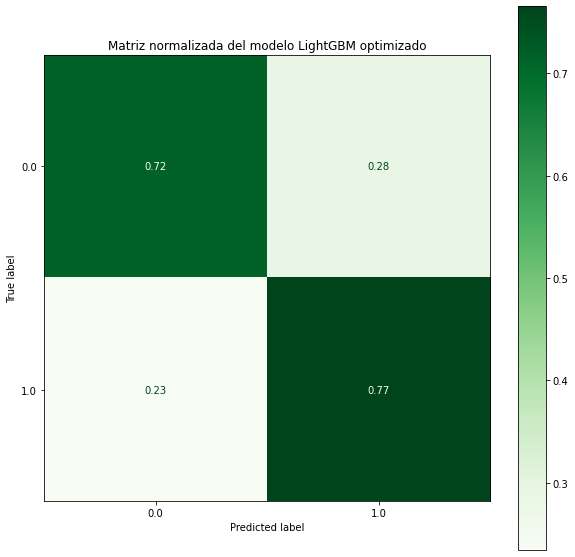

In [ ]:
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize='true',
                                                       ax=ax)
ax.set_title('Matriz normalizada del modelo LightGBM optimizado')

evaluate_model(ytest, ypred, ypred_proba)


El modelo consigue estimar el 75% de los casos positivos de accidentes mortales y mantiene un 80% de recall en los casos negativos de accidentes no mortales, esto es balance que consideramos adecuado en comparación con el resultado del resto de modelos.
 
No ha sido necesario realizar un ajuste de threshold ya que se ha ejecutado correctamente el parámetro *scoring = 'roc_auc'*.

## Interpretabilidad

In [ ]:
# Manipulacion
import pandas as pd
import numpy as np

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos y operaciones 
import sklearn

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# El XGBoost
from sklearn.ensemble import GradientBoostingClassifier 

# Evaluación de modelos
from sklearn import metrics # Evaluación de modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

#regex
import re

#matplotlib
import matplotlib
import matplotlib.pyplot as plt

# Cargar modelos
import pickle 


# Ocultar warnings
import warnings
warnings.filterwarnings('ignore')

# Explicabilidad e Interpretabilidad

utilizamos la librería pickle para cargar el modelo optimizado que generamos en el notebook anterior

Generamos las predicciones de la serie test

In [ ]:
# Generamos predicciones
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)

# Curva ROC
Curva ROC
La curva ROC es una representación gráfica que combina los valores de *sensitividad* = $TP/(TP+FN)$ y *especificabilidad*= $TN/(TN+FP)$.
 
Si para un threshold concreto de la curva ROC la probabilidad de clasificar un valor como clase + se encuentra por encima de la propia curva ROC, se clasificara como clase +.En cambio, si se encontrara por debajo le adjudicaríamos la clase negativa. 
 
El eje Y mide la probabilidad de predecir correctamente un valor +, mientras que el eje X mide la probabilidad de predecir incorrectamente un valor negativo.
 
En un escenario óptimo, el eje Y será 1 para todo el recorrido de la curva ROC. En nuestro caso esto no ocurre.


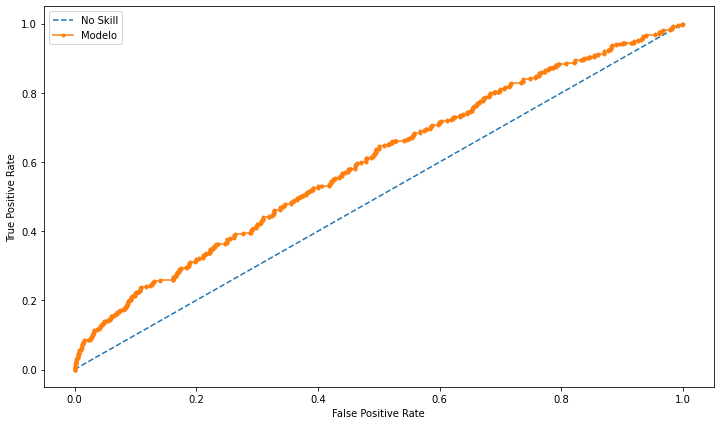

In [ ]:
    # keep probabilities for the positive outcome only
    matplotlib.rcParams['figure.figsize'] = (12, 7)
    yhat = ypred_proba[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(ytest, yhat)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label="Modelo")
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()

1. ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

 

Podemos observar que los vehiculos con mayor número de accidentes y mas accidentes mortales son los "light Duty"

Vemos los primeros años se incrementa enormemente el número de accidentes, pero se va reduciendo gradualmente, asi que de los accidentes hay un mayor número de ellos con coches más nuevos. Pero vemos que hay mayor tasa de mortalidad con coches más antiguos, probablemente por las medidas de seguridad que tiene


Podemos observar que hay un mayor número de accidentes (también mortales) en los que los conductores son hombres y que la tasa de mortalidad es mas alta.
Podemos observar que los conductores con más accidentes son los jóvenes entre 16 y 25 años, pero que las tasa de mortalidad se incrementa con los años


 2. ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?





Los vehículos menos propensos a tener accidentes son por ejemplo los autobuses escolares, las motorhome, o algunas de trabajo como agrarias o de bomberos

Y teniendo en cuenta el tiempo que tiene el coche, los coches que menos accidentes tienen son los que tienen más de 30 años.



Como hemos comentado antes los hombres tienen mas accidentes, por lo tanto las mujeres tienen menos. En cuanto a la edad, teniendo en cuenta a aquellos que pueden conducir (mayores de edad) únicamente, los que menos accidentes tienen son aquellos que tienen mas años. 

3. ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?


Mediante el analisis de V Cramer hemos podido observar que el tipo de accidente es lo que más afecta a la fatality, es decir, a que el accidente suponga una muerte

4. Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas.

Si fueramos una compañía de seguros que tiene un cliente potencial y tiene que decidir si le compensa o no asegurarlo en función de sus características y si la aseguradora como es el caso esta interesada en conocer los gastos hospitalarios derivados del propio accidente. Para ello tendriamos que codificar la variable objetivo como binaria de manera que tomará el valor 0 = si no hubiera heridos y 1 si si hubiera heridos o fallecidos.



5. Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones). 

Hemos generado varios modelos, y hemos llegado a la conclusion que los modelos que mejor funcionan son  LIGhtGBM y Random forest
Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc. 



6. Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc. 

Los inviernos prolongados y extremadamente fríos en Canadá son una ocasión propicia para que las personas den rienda suelta a su pasión por los deportes y actividades exteriores invernales, pero también son, a veces, parte de accidentes que pueden llegar a ser mortales. Podemos concretar que en Enero la probabilidad de accidentes  es muy alta, es un mes en el que las precipitaciones son más abundantes lo que afecta directamente al riesgo de que ocurra una fatalidad de un herido/fallecido.